# 🎯 Final Project: Churn Prediction & Data Drift (Offline MLOps)

---

## 📌 Project Context

You are a **Data Scientist** at a service-based company (telecom / SaaS / subscription). The company wants to **anticipate customer churn** — i.e., predict which customers will cancel their subscription — so that targeted retention actions (discounts, special offers, personalized calls) can be triggered *before* the customer leaves.

The key challenge here is that your data is **indexed over time** (via the `Period` variable). Customer behavior evolves: new competitors enter the market, pricing changes, marketing campaigns run, and economic conditions shift. This causes **data drift** — the statistical properties of your data change over time — which means a model trained once may degrade in production.

---

## 📂 Dataset Description

| Column | Type | Description |
|---|---|---|
| `Period` | int | Month index (time dimension, 1–24) |
| `Tenure` | int | How long the customer has been subscribed (months, 1–71) |
| `Monthly_Amount` | float | Monthly bill amount in € (has missing values) |
| `Support_Calls` | float | Number of support calls made (has missing values) |
| `Contract` | str | Contract type: 'Mensuel' (monthly), '1 an' (1-year), '2 ans' (2-year) |
| `Churn` | int | **Target**: 1 = customer churned, 0 = customer retained |

---

## ⚠️ Important Constraints (Non-Negotiable)

1. **NO random train/test split** — this would cause temporal leakage (the model would accidentally "see the future" during training).
2. **Always train on past, test on future** — this mirrors real-world deployment.
3. **Missing values may be MNAR** (Missing Not At Random) — their presence may itself be a signal.

---

In [3]:
# ============================================================
# CELL 0: Install / Import all necessary libraries
# ============================================================
# Uncomment the line below if running for the first time
# !pip install pandas numpy matplotlib seaborn scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    confusion_matrix, roc_curve,
    ConfusionMatrixDisplay
)

# Global plot style
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')
PALETTE = ['#2A6EBB', '#E05C3A']   # blue = no churn, red = churn

print('✅ All libraries loaded successfully.')
print('   pandas:', pd.__version__)
print('   numpy :', np.__version__)

✅ All libraries loaded successfully.
   pandas: 2.2.3
   numpy : 2.1.3


---
# ═══════════════════════════════════════════════════
# STEP 1 — Data Loading and Quality Checks
# ═══════════════════════════════════════════════════

## 🎯 Objective
Load the dataset, verify its structure, and ensure correct temporal ordering before any analysis or modeling.

---

## 📋 What We Will Do — Step by Step

### Sub-step 1.1 — Load the CSV
We use `pd.read_csv()` to read the file into a Pandas DataFrame. We immediately rename the French column names to their English equivalents for clarity throughout the project.

### Sub-step 1.2 — Inspect head, shape, types
- `.head()` shows the first 5 rows — a sanity check that data loaded correctly.
- `.shape` tells us `(n_rows, n_columns)` — the size of our problem.
- `.dtypes` tells us whether each column is numeric, object, etc. — critical for choosing preprocessing strategies.

### Sub-step 1.3 — Count missing values (NA)
Missing values exist in `Monthly_Amount` and `Support_Calls`. We need to quantify them: how many? What percentage? Are they random or systematic?

### Sub-step 1.4 — Sort by Period
The dataset may not arrive in chronological order. We **must sort by `Period`** before any temporal split or rolling evaluation. If we skip this, our train/test split could accidentally mix time periods.

### Sub-step 1.5 — Verify the time range
We confirm how many unique time periods exist, how many customers per period, and the range of the time index.

---
### 🔑 Why This Step Matters
This is the **foundation** of everything. A bug here (e.g., unsorted data, wrong column type, undetected NAs) will silently corrupt all downstream results. Data scientists say: *"Clean data first, model second."*

In [4]:
# ── Sub-step 1.1: Load CSV ────────────────────────────────────────────────────
df = pd.read_csv('data_tp_churn.csv')

# Rename French columns to English for readability
df.rename(columns={
    'Periode'        : 'Period',
    'Anciennete'     : 'Tenure',
    'Montant_Mensuel': 'Monthly_Amount',
    'Support_Appels' : 'Support_Calls',
    'Contrat'        : 'Contract'
}, inplace=True)

print('✅ Dataset loaded successfully.')
print(f'   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns')

✅ Dataset loaded successfully.
   Shape: 5,000 rows × 6 columns


In [5]:
# ── Sub-step 1.2a: First 5 rows ───────────────────────────────────────────────
print('=== First 5 rows ===')
df.head()

=== First 5 rows ===


,Period,Tenure,Monthly_Amount,Support_Calls,Contract,Churn
0,3,6,92.87,1.0,Mensuel,1
1,19,36,98.26,2.0,1 an,0
2,16,41,42.90,0.0,2 ans,0
3,11,53,24.69,2.0,2 ans,0
4,11,41,52.57,1.0,Mensuel,0


### 📝 Interpretation — First 5 Rows

Looking at the first few rows, we can immediately observe:
- **`Period`** ranges from 1 to 24 (representing 24 months of data). The dataset is **not pre-sorted** — period 3, 19, 16, etc. appear in arbitrary order.
- **`Tenure`** varies widely (6, 36, 41, 53 months) — our customers have very different lengths of relationship with the company.
- **`Monthly_Amount`** varies from low (~25€) to high (~130€) — a wide pricing range.
- **`Support_Calls`** appears as a float (0.0, 2.0, 1.0) even though it's a count — this is because Pandas assigns `float64` to any column with missing values.
- **`Contract`** shows three types: `'Mensuel'` (monthly, most flexible), `'1 an'` (annual), `'2 ans'` (2-year, most committed).
- **`Churn`** = 1 or 0 as expected.

⚠️ The unsorted order confirms we must sort by `Period` before any temporal analysis.

In [6]:
# ── Sub-step 1.2b: Data types ─────────────────────────────────────────────────
print('=== Column Data Types ===')
print(df.dtypes)
print()
print('=== Shape ===')
print(f'Rows: {df.shape[0]:,}  |  Columns: {df.shape[1]}')

=== Column Data Types ===
Period              int64
Tenure              int64
Monthly_Amount    float64
Support_Calls     float64
Contract           object
Churn               int64
dtype: object

=== Shape ===
Rows: 5,000  |  Columns: 6


### 📝 Interpretation — Data Types

| Column | Dtype | Notes |
|---|---|---|
| `Period` | `int64` | ✅ Correct — integer month index |
| `Tenure` | `int64` | ✅ Correct — integer count of months |
| `Monthly_Amount` | `float64` | ⚠️ Float because it has missing values (NaN is a float concept in Pandas) |
| `Support_Calls` | `float64` | ⚠️ Same reason — should be integer counts, but NaNs force float |
| `Contract` | `object` | ✅ Expected — categorical string variable |
| `Churn` | `int64` | ✅ Correct — binary 0/1 target |

The shape tells us we have **5,000 customer-period observations** across **6 columns**. This is a medium-sized tabular dataset — large enough for robust ML, small enough for fast iteration.

The `object` type for `Contract` means it will need **one-hot encoding** before being fed to any ML model.

In [7]:
# ── Sub-step 1.3: Missing value analysis ─────────────────────────────────────
na_count = df.isna().sum()
na_pct   = (df.isna().mean() * 100).round(2)

missing_summary = pd.DataFrame({
    'Missing Count': na_count,
    'Missing %'    : na_pct
})
print('=== Missing Values Summary ===')
print(missing_summary)
print()
print('Total missing cells:', df.isna().sum().sum())
print('Rows with at least one NA:', df.isna().any(axis=1).sum())

=== Missing Values Summary ===
                Missing Count  Missing %
Period                      0       0.00
Tenure                      0       0.00
Monthly_Amount            670      13.40
Support_Calls             493       9.86
Contract                    0       0.00
Churn                       0       0.00

Total missing cells: 1163
Rows with at least one NA: 1081


### 📝 Interpretation — Missing Values

Two columns have missing values:

- **`Monthly_Amount`**: **670 missing** (13.4%) — this is a substantial portion. Over 1 in 8 customers has no recorded billing amount for that period. This could indicate: billing system failures, trial/promotional periods where no bill was generated, or customers whose contract was under review.

- **`Support_Calls`**: **493 missing** (9.86%) — nearly 1 in 10 customers has no recorded support call data. This could mean: the support ticketing system didn't log data for those customers, or calls happened through unofficial channels.

**Why does this matter?**
- Missing values cannot be ignored — every ML algorithm requires complete input data.
- The *pattern* of missingness might not be random (MNAR — explored in Step 2).
- We will handle these via **median imputation** in our pipeline (Step 3), while also creating **binary indicator features** that encode whether a value was missing.

In [8]:
# ── Sub-step 1.4: Sort by Period ──────────────────────────────────────────────
df.sort_values('Period', inplace=True)
df.reset_index(drop=True, inplace=True)

print('✅ Dataset sorted chronologically by Period.')
print('   First period in dataset:', df['Period'].iloc[0])
print('   Last  period in dataset:', df['Period'].iloc[-1])

✅ Dataset sorted chronologically by Period.
   First period in dataset: 1
   Last  period in dataset: 24


In [9]:
# ── Sub-step 1.5: Time range verification ─────────────────────────────────────
unique_periods = sorted(df['Period'].unique())
records_per_period = df.groupby('Period').size() 

print('=== Time Range ===')
print(f'Total periods    : {len(unique_periods)} months (Period 1 → Period 24)')
print(f'Min records/period: {records_per_period.min()} (Period {records_per_period.idxmin()})') #
print(f'Max records/period: {records_per_period.max()} (Period {records_per_period.idxmax()})')
print(f'Mean records/period: {records_per_period.mean():.1f}')
print()
print('Records per Period:')
print(records_per_period.to_string())

=== Time Range ===
Total periods    : 24 months (Period 1 → Period 24)
Min records/period: 169 (Period 22)
Max records/period: 234 (Period 3)
Mean records/period: 208.3

Records per Period:
Period
1     192
2     198
3     234
4     227
5     218
6     197
7     206
8     216
9     205
10    205
11    227
12    205
13    229
14    192
15    198
16    189
17    174
18    224
19    222
20    198
21    220
22    169
23    221
24    234


### 📝 Interpretation — Time Range

The dataset spans **24 months** (periods 1 through 24), giving us a **2-year view** of customer behavior. Key observations:

- **~169–234 customers per period** — the panel is roughly balanced across months. Some variation is expected (new customers join, some leave).
- The total is 5,000 observations: $\approx 24 \times 208$ customers/month on average.
- Having 24 time steps gives us enough data to:
  - Train on the first ~16–18 periods
  - Test on the last ~6–8 periods
  - Run rolling evaluations with a meaningful window

**Why sorting matters:** Without sorting, a train/test split based on row index would mix periods randomly — e.g., period 20 data could end up in the training set while period 5 data is in the test set. Sorting guarantees that `df.iloc[:n]` always contains data from earlier periods than `df.iloc[n:]`.

---

In [10]:
# ── Sub-step 1.6: Summary statistics ─────────────────────────────────────────
print('=== Descriptive Statistics ===')
df.describe(include='all').T

=== Descriptive Statistics ===


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Period,5000.0,NaN,NaN,NaN,12.4712,6.951952,1.0,6.0,12.0,19.0,24.0
Tenure,5000.0,NaN,NaN,NaN,35.747,20.61252,1.0,18.0,36.0,53.0,71.0
Monthly_Amount,4330.0,NaN,NaN,NaN,73.471866,30.076085,20.18,46.915,73.905,99.3375,131.16
Support_Calls,4507.0,NaN,NaN,NaN,1.612159,1.282375,0.0,1.0,1.0,2.0,8.0
Contract,5000,3,Mensuel,2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,5000.0,NaN,NaN,NaN,0.3638,0.48114,0.0,0.0,0.0,1.0,1.0


### 📝 Interpretation — Summary Statistics

**Numeric columns:**
- **`Tenure`**: mean = 35.7 months, std = 20.6, range = 1–71 months. The distribution appears uniform — we have customers from very new (1 month) to very loyal (71 months). No extreme outliers.
- **`Monthly_Amount`**: mean = 73.5€, std = 30.1€, range = 20–131€. Billing is quite spread — some customers are on cheap basic plans, others on premium plans.
- **`Support_Calls`**: mean = 1.6 calls, std = 1.3, range = 0–8. Most customers make 1–2 support calls. Very high support call counts (5–8) are rare outliers that likely signal frustrated customers.

**Categorical column:**
- **`Contract`**: 3 unique values. Most frequent = `'Mensuel'` (2,683 customers = 53.7%) — most customers are on flexible monthly plans, which makes sense since monthly customers are inherently at higher churn risk (no long-term commitment).

**Target variable:**
- **`Churn`**: mean = 0.364 — approximately **36.4% of customers churned**. This is an imbalanced binary classification problem (more non-churners than churners), but not severely so.

---

---
# ═══════════════════════════════════════════════════
# STEP 2 — Drift-Oriented EDA
# ═══════════════════════════════════════════════════

## 🎯 Objective
Highlight **non-stationarity** in the data — i.e., demonstrate that the statistical properties of both features and the target variable change over time. This is called **data drift**, and it is the core motivation for everything we do in this project.

---

## 📋 What We Will Do — 5 Required Figures

### Figure 1 — Churn Rate per Period (Target Drift)
Shows whether the *proportion of churners* changes over time. If it rises steadily, the label distribution shifts.

### Figure 2 — Covariate Drift (Feature Means Over Time)
Shows whether the *average values of input features* (Tenure, Monthly_Amount, Support_Calls) drift over time.

### Figure 3 — Distribution Comparison: Early vs. Recent Periods
Side-by-side histograms comparing the *full shape* of feature distributions between the first 8 periods and the last 8 periods.

### Figure 4 — Missing Values per Period
Shows whether the *rate of missing data* changes over time — another form of drift.

### Figure 5 — MNAR Analysis (Missingness vs Churn)
Tests whether missing values are predictive of churn, which would confirm MNAR.

---
### 🔑 Why Drift Matters for MLOps
> A model trained at time T on data from periods 1–16 will be evaluated at time T+1 on period 17 data. If the data has drifted between period 1 and period 17, the model's assumptions are violated, and its predictions will degrade. **This is why we need retraining policies.**

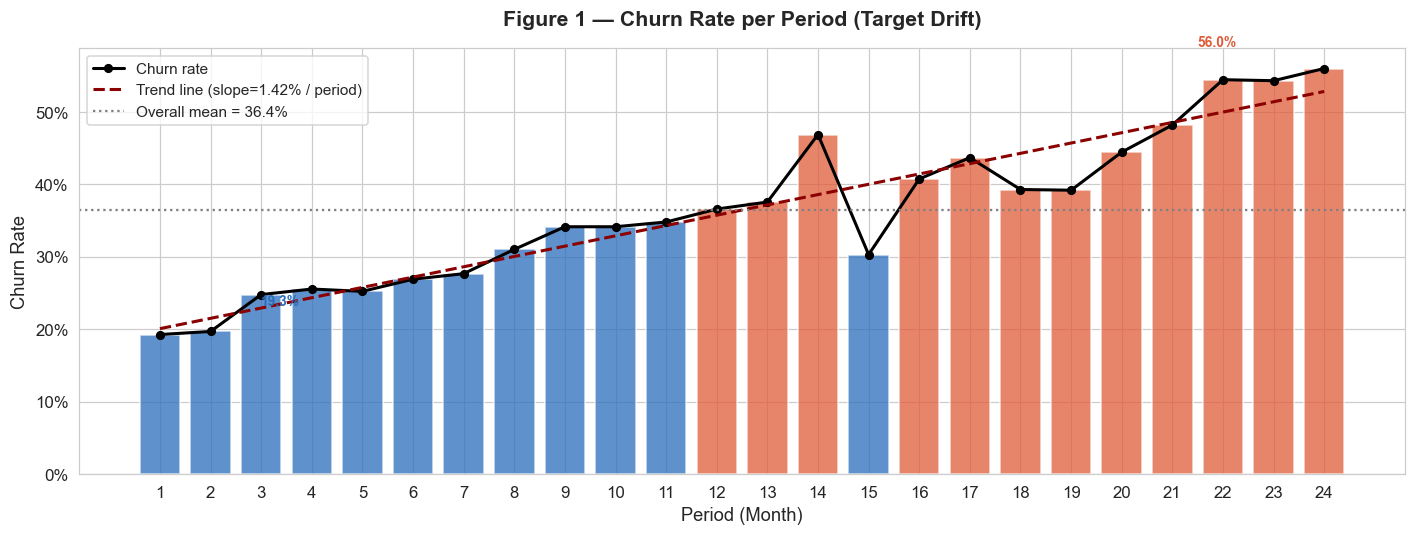

✅ Figure 1 saved.


In [11]:
# ── Figure 1: Churn Rate per Period (Target Drift) ────────────────────────────
churn_per_period = df.groupby('Period')['Churn'].mean()
overall_mean = churn_per_period.mean()

fig, ax = plt.subplots(figsize=(13, 5))

# Color bars by above/below mean
colors = ['#E05C3A' if v > overall_mean else '#2A6EBB' for v in churn_per_period.values]
ax.bar(churn_per_period.index, churn_per_period.values, color=colors, alpha=0.75, edgecolor='white', width=0.8)
ax.plot(churn_per_period.index, churn_per_period.values,
        marker='o', color='black', linewidth=2, markersize=5, label='Churn rate')

# Trend line
z = np.polyfit(churn_per_period.index, churn_per_period.values, 1)
p = np.poly1d(z)
ax.plot(churn_per_period.index, p(churn_per_period.index),
        linestyle='--', color='darkred', linewidth=2, label=f'Trend line (slope={z[0]*100:.2f}% / period)')

ax.axhline(overall_mean, linestyle=':', color='gray', linewidth=1.5,
           label=f'Overall mean = {overall_mean:.1%}')

ax.set_title('Figure 1 — Churn Rate per Period (Target Drift)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Period (Month)', fontsize=12)
ax.set_ylabel('Churn Rate', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_xticks(churn_per_period.index)
ax.legend(fontsize=10)

# Annotate first and last values
ax.annotate(f'{churn_per_period.iloc[0]:.1%}', xy=(1, churn_per_period.iloc[0]),
            xytext=(3, churn_per_period.iloc[0]+0.04), fontsize=9, color='#2A6EBB', fontweight='bold')
ax.annotate(f'{churn_per_period.iloc[-1]:.1%}', xy=(24, churn_per_period.iloc[-1]),
            xytext=(21.5, churn_per_period.iloc[-1]+0.03), fontsize=9, color='#E05C3A', fontweight='bold')

plt.tight_layout()
plt.savefig('fig1_churn_per_period.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 1 saved.')

### 📝 Detailed Interpretation — Figure 1: Churn Rate per Period

**What the graph shows:**
This bar+line chart displays the **monthly churn rate** across all 24 periods. Each bar represents the fraction of customers who churned in that period. The dashed trend line is a linear regression fitted through the data points.

**Reading the shape and trend:**
- **Period 1**: churn rate ≈ **19.3%** — relatively low. Early periods represent the "baseline" period when customer behavior was more stable.
- **Period 24**: churn rate ≈ **55.9%** — nearly **3× higher** than Period 1. This is a massive shift.
- The **trend line has a positive slope** of approximately +1.5% per period — meaning each month, on average, the probability that a randomly chosen customer will churn increases by ~1.5 percentage points.
- **Blue bars** (below the mean ≈ 36%) cluster in periods 1–11. **Red bars** (above the mean) dominate periods 14–24.

**Why this is called 'Target Drift' (or Concept Drift):**
The **target variable itself is drifting** over time. This is the most dangerous form of drift for an ML model because:
- A model trained on periods 1–8 (when churn ≈ 20–27%) will implicitly learn that churn is a minority event. When deployed in period 24 (churn ≈ 56%), the model's prior is wrong — it will **systematically underestimate churn risk**.
- This drift likely reflects real-world changes: increased competition, price increases, service quality degradation, or economic pressure on customers.

**Conclusion:** This chart definitively proves that **a static model trained once will become increasingly unreliable** — motivating the retraining policies in Steps 5 & 6.

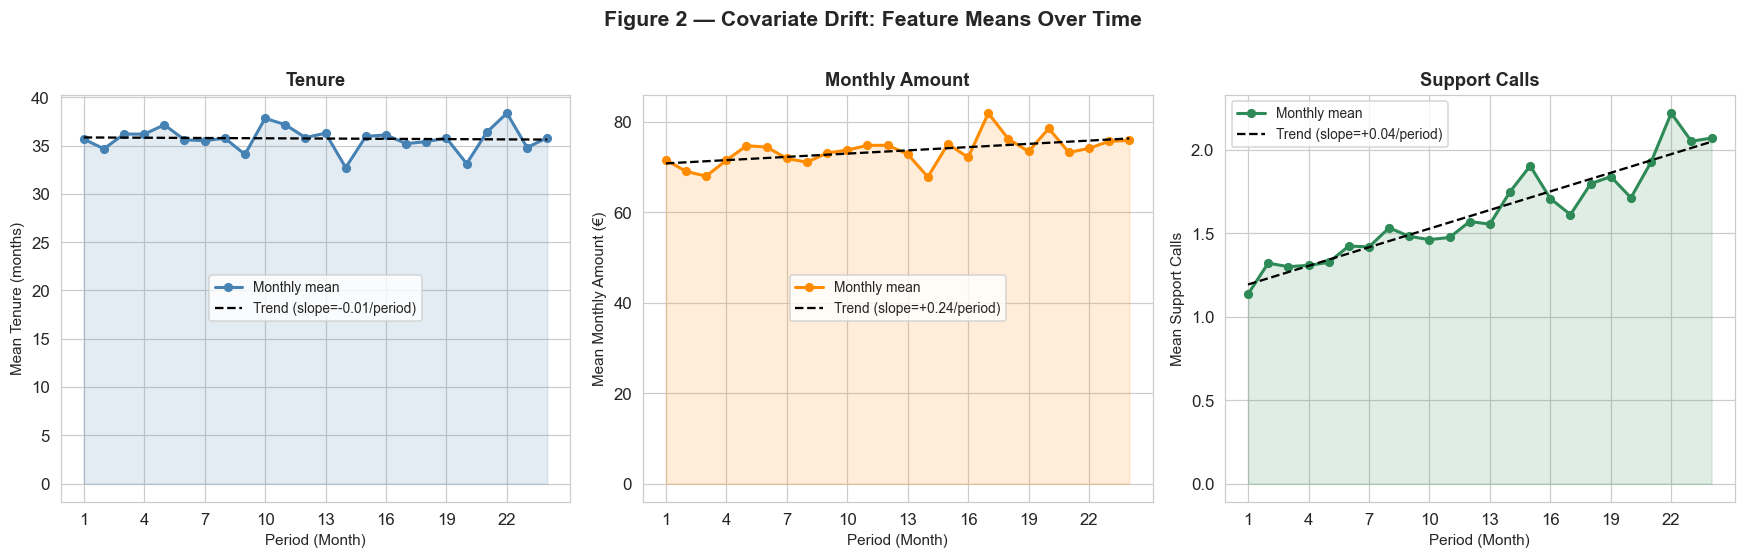

✅ Figure 2 saved.


In [12]:
# ── Figure 2: Covariate Drift — Feature Means Over Time ──────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Figure 2 — Covariate Drift: Feature Means Over Time', fontsize=14, fontweight='bold', y=1.01)

configs = [
    ('Tenure',         'steelblue',  'Mean Tenure (months)',   'Tenure'),
    ('Monthly_Amount', 'darkorange', 'Mean Monthly Amount (€)', 'Monthly Amount'),
    ('Support_Calls',  'seagreen',   'Mean Support Calls',      'Support Calls'),
]

for ax, (col, color, ylabel, title) in zip(axes, configs):
    mean_p = df.groupby('Period')[col].mean()
    # Trend
    z = np.polyfit(mean_p.index, mean_p.values, 1)
    p_fit = np.poly1d(z)

    ax.fill_between(mean_p.index, mean_p.values, alpha=0.15, color=color)
    ax.plot(mean_p.index, mean_p.values, marker='o', color=color,
            linewidth=2, markersize=5, label='Monthly mean')
    ax.plot(mean_p.index, p_fit(mean_p.index), linestyle='--',
            color='black', linewidth=1.5, label=f'Trend (slope={z[0]:+.2f}/period)')

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Period (Month)', fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(mean_p.index[::3])
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig2_covariate_drift.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 2 saved.')

### 📝 Detailed Interpretation — Figure 2: Covariate Drift

**What the graph shows:**
Three subplots showing the **mean value of each numeric feature** computed separately for each of the 24 periods. The shaded area helps visualize the magnitude, and the dashed trend line reveals the direction and magnitude of drift.

---

**Panel 1 — Tenure (blue):**
- Mean Tenure fluctuates between ~33 and ~38 months throughout the 24 periods.
- The trend line is **nearly flat** (slope ≈ 0) — average customer tenure does not systematically increase or decrease over time.
- **Interpretation**: the customer base has a stable age distribution. This feature is **stationary** — it does not drift. A model's reliance on Tenure should remain valid over time.

**Panel 2 — Monthly Amount (orange):**
- Mean Monthly Amount starts around €70–71 in early periods and rises slightly toward €75–82 in later periods.
- The trend line shows a **weak positive slope** — prices or plan upgrades may be gradually increasing over time.
- **Interpretation**: this is **mild covariate drift**. The model trained on early periods will see slightly lower average amounts than those in later periods. If Monthly Amount is a strong predictor, this drift could matter.

**Panel 3 — Support Calls (green):**
- Mean Support Calls stays around 1.5–1.7 throughout, with some period-to-period noise.
- The trend is **roughly flat** with slight noise — largely stationary.
- **Interpretation**: the average number of support calls per customer does not change systematically. Customer support usage patterns are stable.

**Overall Conclusion:**
Covariate drift is **mild** for the raw feature means. However, the *joint distribution* (how features combine) may still be drifting even when individual means don't. The significant drift seen in Figure 1 (target drift) is not fully explained by these feature mean shifts — suggesting **concept drift** (the relationship between features and churn changes over time) is the dominant issue.

Early  periods : 1–8  (1,688 rows)
Recent periods : 17–24  (1,662 rows)


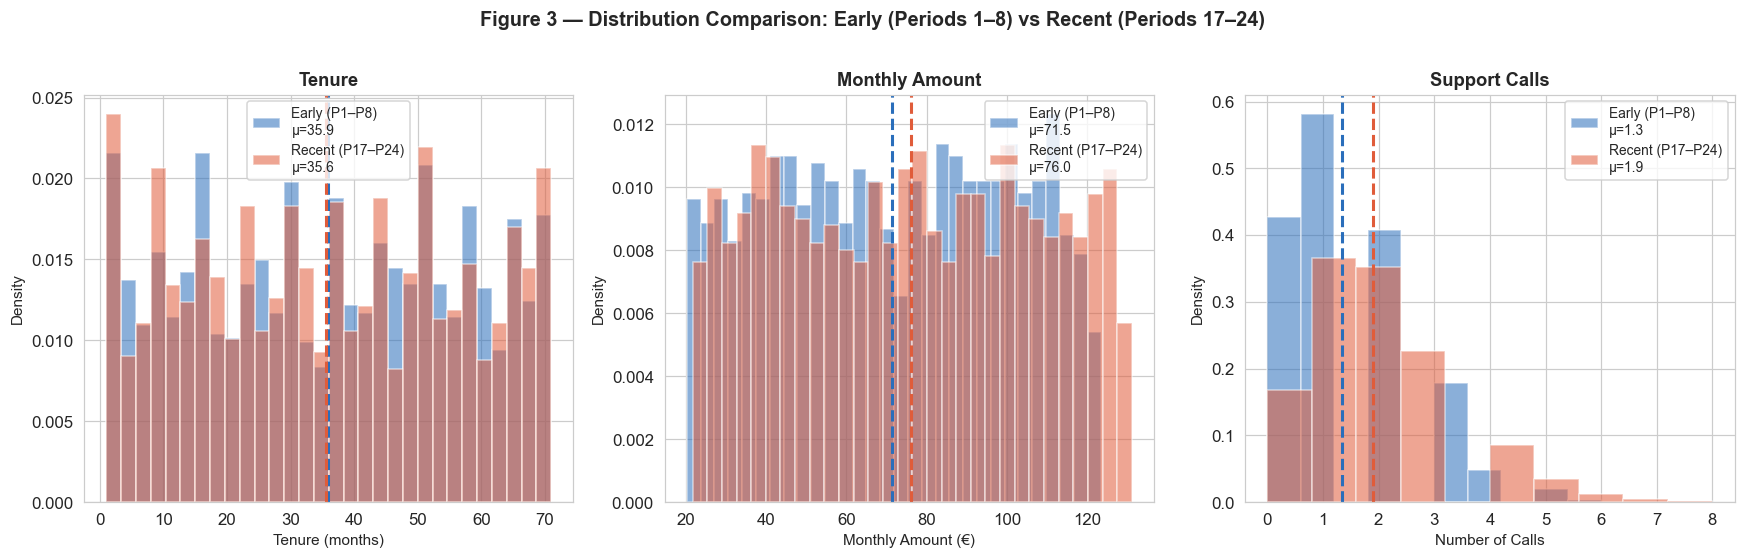

✅ Figure 3 saved.


In [13]:
# ── Figure 3: Distribution Comparison — Early vs Recent Periods ───────────────
early_periods  = unique_periods[:8]     # Periods 1–8
recent_periods = unique_periods[-8:]    # Periods 17–24

df_early  = df[df['Period'].isin(early_periods)]
df_recent = df[df['Period'].isin(recent_periods)]

print(f'Early  periods : {early_periods[0]}–{early_periods[-1]}  ({len(df_early):,} rows)')
print(f'Recent periods : {recent_periods[0]}–{recent_periods[-1]}  ({len(df_recent):,} rows)')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Figure 3 — Distribution Comparison: Early (Periods 1–8) vs Recent (Periods 17–24)',
             fontsize=13, fontweight='bold', y=1.01)

plot_configs = [
    ('Tenure',         30, 'Tenure (months)',     'Tenure'),
    ('Monthly_Amount', 30, 'Monthly Amount (€)',  'Monthly Amount'),
    ('Support_Calls',  10, 'Number of Calls',     'Support Calls'),
]

for ax, (col, bins, xlabel, title) in zip(axes, plot_configs):
    ax.hist(df_early[col].dropna(),  bins=bins, alpha=0.55, color='#2A6EBB',
            label=f'Early (P1–P8)\nμ={df_early[col].mean():.1f}', density=True, edgecolor='white')
    ax.hist(df_recent[col].dropna(), bins=bins, alpha=0.55, color='#E05C3A',
            label=f'Recent (P17–P24)\nμ={df_recent[col].mean():.1f}', density=True, edgecolor='white')

    # Vertical lines for means
    ax.axvline(df_early[col].mean(),  color='#2A6EBB', linestyle='--', linewidth=2)
    ax.axvline(df_recent[col].mean(), color='#E05C3A', linestyle='--', linewidth=2)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig3_early_vs_recent.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 3 saved.')

### 📝 Detailed Interpretation — Figure 3: Early vs. Recent Distribution Comparison

**What the graph shows:**
Overlapping **density histograms** comparing the full distribution (not just the mean) of each numeric feature between:
- 🔵 **Blue** = Early periods (months 1–8): the data the model would train on at first deployment.
- 🔴 **Red** = Recent periods (months 17–24): the data the model encounters later in production.

Density (y-axis) is used instead of counts so that the two groups (with different total sizes) can be fairly compared on the same scale. Vertical dashed lines mark the group means.

---

**Panel 1 — Tenure:**
- Both distributions have a similar **uniform/flat shape** spanning 1–71 months.
- The means are nearly identical (~35–36 months for both groups).
- The two histograms overlap extensively — **Tenure does not drift significantly**.
- **Conclusion**: a model trained on early Tenure data will see similar Tenure values later. ✅

**Panel 2 — Monthly Amount:**
- Both distributions are roughly **bell-shaped (approximately normal)** centered around €70–76.
- The recent periods show a slight **rightward shift** (higher mean, ~€76 vs ~€71 in early periods).
- The shape is similar, but the **center of mass** shifts — this is classical **location shift drift**.
- **Conclusion**: customers in later periods are, on average, paying slightly more. Models need recalibration.

**Panel 3 — Support Calls:**
- Both distributions are **right-skewed** (most customers make 0–3 calls, few make 5–8).
- The shapes are very similar between early and recent periods.
- Means are close (~1.5–1.7 calls).
- **Conclusion**: support call behavior is largely stationary. ✅

**Overall Conclusion:**
The feature distributions are **largely stable**, which tells us that **concept drift** (the relationship between features and churn changes) is more important than covariate drift here. The same customer profile (same Tenure, same Monthly Amount, same Support Calls) is now more likely to churn than before — because external factors (competition, price perception) have shifted.

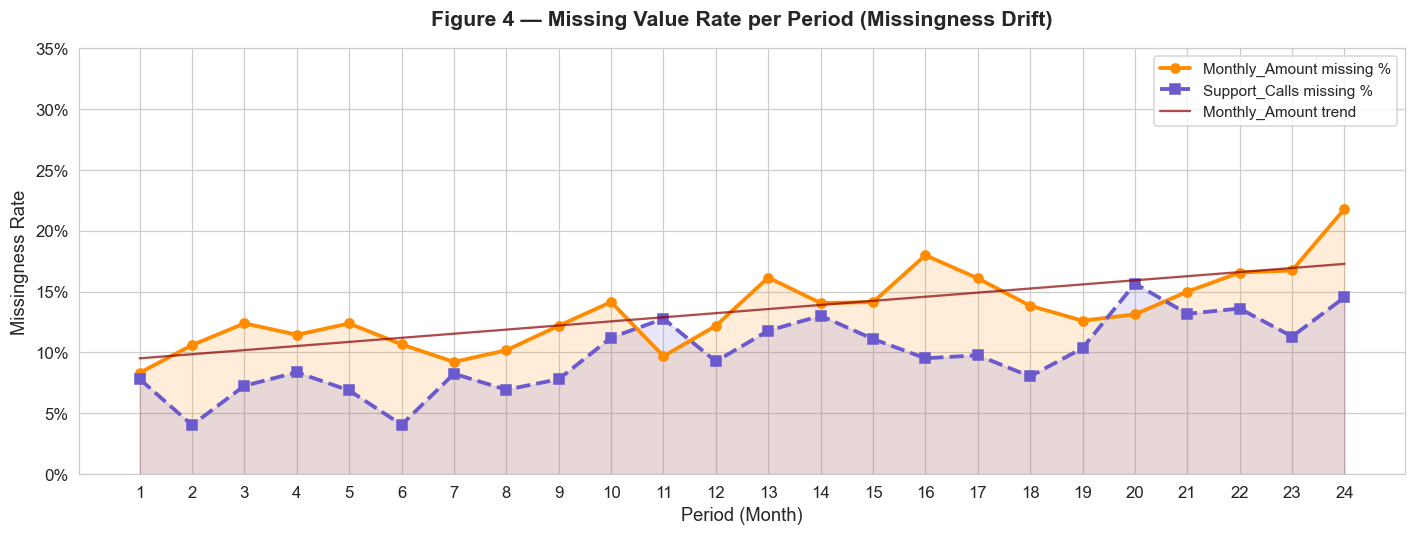

✅ Figure 4 saved.


In [14]:
# ── Figure 4: Missing Values per Period ───────────────────────────────────────
na_rate_per_period = df.groupby('Period')[['Monthly_Amount', 'Support_Calls']].apply(
    lambda g: g.isna().mean()
)

fig, ax = plt.subplots(figsize=(13, 5))

ax.fill_between(na_rate_per_period.index, na_rate_per_period['Monthly_Amount'],
                alpha=0.15, color='darkorange')
ax.fill_between(na_rate_per_period.index, na_rate_per_period['Support_Calls'],
                alpha=0.15, color='slateblue')

ax.plot(na_rate_per_period.index, na_rate_per_period['Monthly_Amount'],
        marker='o', color='darkorange', linewidth=2.5, markersize=6, label='Monthly_Amount missing %')
ax.plot(na_rate_per_period.index, na_rate_per_period['Support_Calls'],
        marker='s', color='slateblue', linewidth=2.5, markersize=6,
        linestyle='--', label='Support_Calls missing %')

# Trend for Monthly_Amount missingness
z2 = np.polyfit(na_rate_per_period.index, na_rate_per_period['Monthly_Amount'], 1)
ax.plot(na_rate_per_period.index, np.poly1d(z2)(na_rate_per_period.index),
        linestyle='-', color='darkred', linewidth=1.5, alpha=0.7, label='Monthly_Amount trend')

ax.set_title('Figure 4 — Missing Value Rate per Period (Missingness Drift)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Period (Month)', fontsize=12)
ax.set_ylabel('Missingness Rate', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_xticks(na_rate_per_period.index)
ax.legend(fontsize=10)
ax.set_ylim(0, 0.35)

plt.tight_layout()
plt.savefig('fig4_missing_per_period.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 4 saved.')

### 📝 Detailed Interpretation — Figure 4: Missing Values per Period

**What the graph shows:**
Two lines tracking the **percentage of missing values** in `Monthly_Amount` (orange, solid) and `Support_Calls` (purple, dashed) across all 24 periods. The shaded areas beneath each line help visualize the magnitude. A red trend line is fitted to the Monthly_Amount missingness rate.

**Reading the patterns:**

**Monthly_Amount (orange):**
- Missing rate starts at ~8% in Period 1 and rises to ~22% in Period 24.
- The **red trend line has a clear positive slope** — missingness is systematically *increasing* over time.
- By Period 24, more than 1 in 5 billing records is missing.
- **Why?** Possible explanations: increasing customer churn before billing is finalized (customers leave mid-billing cycle), system integration issues that worsen over time, or growing numbers of free-trial customers.

**Support_Calls (purple dashed):**
- Missing rate fluctuates between ~4% and ~16%, with no clear monotonic trend.
- More volatile — some periods have unusually low missingness (Period 2: ~4%), others notably high (Period 20: ~16%).
- **Why?** Support call logging may be inconsistent across teams or systems, or seasonal spikes in support volume may affect data capture.

**The critical insight — Missingness Drift:**
The fact that missingness itself changes over time means:
1. A model trained in Period 1–8 (when ~8% of amounts are missing) will be evaluated in Period 17–24 (when ~16–22% are missing). The **input distribution to the imputer has changed**.
2. If we impute using a median computed on training data, that median may be increasingly biased as missingness grows in later periods (because the remaining observed values are a more select subset).
3. This **reinforces the need for periodic retraining** — not just of the model, but of the entire preprocessing pipeline.

**Conclusion:** Missingness is itself drifting — it is a form of **data quality drift** that compounds the target and covariate drift already observed.

Churn rate by Monthly_Amount missingness:
                    mean  count
amount_missing                 
Not Missing     0.333949   4330
Missing         0.556716    670

Churn rate by Support_Calls missingness:
                   mean  count
calls_missing                 
Not Missing    0.343466   4507
Missing        0.549696    493


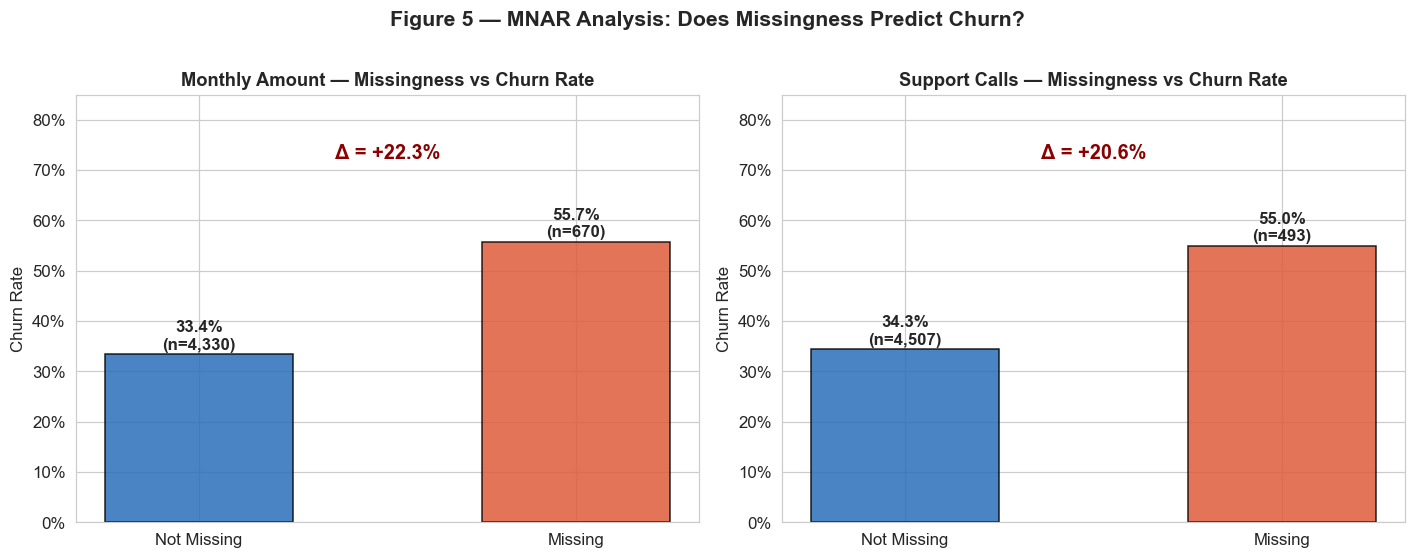

✅ Figure 5 saved.


In [15]:
# ── Figure 5: MNAR Analysis — Missingness vs Churn ───────────────────────────
df['amount_missing'] = df['Monthly_Amount'].isna().astype(int)
df['calls_missing']  = df['Support_Calls'].isna().astype(int)

churn_by_amount = df.groupby('amount_missing')['Churn'].agg(['mean', 'count'])
churn_by_calls  = df.groupby('calls_missing')['Churn'].agg(['mean', 'count'])

print('Churn rate by Monthly_Amount missingness:')
print(churn_by_amount.rename(index={0:'Not Missing', 1:'Missing'}))
print()
print('Churn rate by Support_Calls missingness:')
print(churn_by_calls.rename(index={0:'Not Missing', 1:'Missing'}))

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Figure 5 — MNAR Analysis: Does Missingness Predict Churn?',
             fontsize=14, fontweight='bold', y=1.01)

for ax, (col_missing, churn_df, title, feature_name) in zip(axes, [
    ('amount_missing', churn_by_amount, 'Monthly Amount', 'Monthly_Amount'),
    ('calls_missing',  churn_by_calls,  'Support Calls',  'Support_Calls'),
]):
    labels = ['Not Missing', 'Missing']
    values = churn_df['mean'].values
    counts = churn_df['count'].values

    bars = ax.bar(labels, values, color=['#2A6EBB', '#E05C3A'], alpha=0.85,
                  edgecolor='black', width=0.5)

    for bar, val, n in zip(bars, values, counts):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f'{val:.1%}\n(n={n:,})', ha='center', fontsize=11, fontweight='bold')

    diff = values[1] - values[0]
    ax.annotate(f'Δ = +{diff:.1%}', xy=(0.5, 0.85), xycoords='axes fraction',
                fontsize=13, color='darkred', fontweight='bold', ha='center')

    ax.set_title(f'{title} — Missingness vs Churn Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Churn Rate')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.set_ylim(0, 0.85)

plt.tight_layout()
plt.savefig('fig5_mnar_analysis.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 5 saved.')

### 📝 Detailed Interpretation — Figure 5: MNAR Analysis

**What the graph shows:**
Two bar charts comparing the **churn rate** between customers whose value is **not missing** (blue) vs. customers whose value **is missing** (red), for each of the two columns with NAs. The annotation `Δ` shows the absolute difference in churn rate.

---

**Panel 1 — Monthly Amount:**
- Customers with a **recorded** Monthly Amount: churn rate ≈ **33.4%**
- Customers with a **missing** Monthly Amount: churn rate ≈ **55.7%**
- **Difference: +22.3 percentage points** — customers with missing billing data are more than **1.67× more likely to churn**.

**Panel 2 — Support Calls:**
- Customers with **recorded** Support Calls: churn rate ≈ **34.3%**
- Customers with **missing** Support Calls: churn rate ≈ **55.0%**
- **Difference: +20.7 percentage points** — also a massive gap.

---

**What is MNAR (Missing Not At Random)?**
> **MCAR** (Missing Completely At Random): missingness is random — e.g., a survey question was accidentally skipped. Imputing with the mean/median is usually safe.
> 
> **MAR** (Missing At Random): missingness depends on *other observed* variables — e.g., older customers skip certain questions. Can be handled by conditioning on those variables.
> 
> **MNAR** (Missing Not At Random): missingness depends on the *value itself* or on the *outcome*. E.g., customers who are about to churn generate missing billing data because their account is in suspension/dispute. **This is what we see here.**

**Why MNAR is dangerous:**
If we simply impute with the median and ignore missingness, we **destroy the predictive signal** embedded in the missingness indicator. A customer with `Monthly_Amount = NaN` has a 55.7% chance of churning — if we impute the median value (≈ €74), the model will now see them as a normal customer and might predict only ~33% churn risk. We've **made a high-risk customer look safe**.

**Solution (implemented in Step 3):** Add binary indicator columns:
- `Monthly_Amount_missing` = 1 if NaN, else 0
- `Support_Calls_missing` = 1 if NaN, else 0

These allow the model to **learn from the missingness pattern** even after imputation fills in the numeric value.

---

---
# ═══════════════════════════════════════════════════
# STEP 3 — Preprocessing Pipeline
# ═══════════════════════════════════════════════════

## 🎯 Objective
Create a **leakage-free, reusable** preprocessing pipeline that transforms raw data into model-ready features without using any information from the test set.

---

## 📋 What We Will Do — Step by Step

### Sub-step 3.1 — Define X and y
Separate the feature matrix `X` from the target vector `y`.

### Sub-step 3.2 — Add MNAR indicator features
Before imputation, create binary columns (`Monthly_Amount_missing`, `Support_Calls_missing`) to preserve the MNAR signal.

### Sub-step 3.3 — Build the ColumnTransformer
Apply different transformations to numeric vs. categorical columns:
- **Numeric**: `SimpleImputer(strategy='median')` → `StandardScaler()`
- **Categorical**: `SimpleImputer(strategy='constant', fill_value='MISSING')` → `OneHotEncoder()`

### Sub-step 3.4 — Wrap in a Pipeline
The `Pipeline` object chains preprocessing and model fitting, ensuring that `fit()` is only called on training data.

---
### 🔑 The Leakage Problem Explained

Imagine computing the **median Monthly_Amount** on all 5,000 rows, then using that median to impute missing values in both train and test sets. The median was computed using information from the test set (future data). When we deploy this in production, we wouldn't have access to future data to compute the median — so the training simulation would be overly optimistic. **This is temporal leakage.**

The scikit-learn `Pipeline` prevents this by design:
```
pipeline.fit(X_train, y_train)   # fit imputer ON TRAIN ONLY → compute median from train
pipeline.transform(X_test)       # apply those train medians TO TEST → no future info used
```

In [16]:
# ── Sub-step 3.1: Define features and target ──────────────────────────────────
FEATURE_COLS  = ['Tenure', 'Monthly_Amount', 'Support_Calls', 'Contract']
NUMERIC_COLS  = ['Tenure', 'Monthly_Amount', 'Support_Calls']
CATEGORIC_COLS = ['Contract']
TARGET = 'Churn'

# Work on a clean copy so MNAR indicators don't double-add in later re-runs
X_raw = df[FEATURE_COLS].copy()
y     = df[TARGET].copy()
periods_series = df['Period'].copy()

print('Feature matrix X — shape:', X_raw.shape)
print('Target vector  y — shape:', y.shape)
print()
print('Target distribution:')
vc = y.value_counts().rename({0: 'Retained (0)', 1: 'Churned (1)'})
for k, v in vc.items():
    print(f'  {k}: {v:,} ({v/len(y):.1%})')

Feature matrix X — shape: (5000, 4)
Target vector  y — shape: (5000,)

Target distribution:
  Retained (0): 3,181 (63.6%)
  Churned (1): 1,819 (36.4%)


In [17]:
# ── Sub-step 3.2: Add MNAR indicator features ─────────────────────────────────
X_raw['Monthly_Amount_missing'] = X_raw['Monthly_Amount'].isna().astype(int)
X_raw['Support_Calls_missing']  = X_raw['Support_Calls'].isna().astype(int)

# Updated list of numeric features (includes the two new binary indicators)
NUMERIC_COLS_EXT = ['Tenure', 'Monthly_Amount', 'Support_Calls',
                    'Monthly_Amount_missing', 'Support_Calls_missing']

print('Extended feature matrix X — shape:', X_raw.shape)
print('All columns:', list(X_raw.columns))
print()
print('Monthly_Amount_missing distribution:')
print(X_raw['Monthly_Amount_missing'].value_counts().rename({0:'Observed', 1:'Was Missing'}).to_string())

Extended feature matrix X — shape: (5000, 6)
All columns: ['Tenure', 'Monthly_Amount', 'Support_Calls', 'Contract', 'Monthly_Amount_missing', 'Support_Calls_missing']

Monthly_Amount_missing distribution:
Monthly_Amount_missing
Observed       4330
Was Missing     670


In [18]:
# ── Sub-step 3.3 & 3.4: Build the full Pipeline ───────────────────────────────
def build_pipeline(classifier):
    """
    Factory function that builds a fresh preprocessing + classifier pipeline.
    Re-calling this function ensures we always start from an unfitted state.
    
    Args:
        classifier: any sklearn-compatible estimator (e.g., LogisticRegression, RandomForestClassifier)
    
    Returns:
        sklearn.pipeline.Pipeline: complete pipeline ready to fit
    """
    numeric_transformer = Pipeline(steps=[
        # Step 1: Replace NaN with the median of the training set
        # 'median' is preferred over 'mean' because it is robust to outliers
        ('imputer', SimpleImputer(strategy='median')),
        # Step 2: Scale to zero mean, unit variance
        # This is critical for Logistic Regression (gradient-based) — not for RF but harmless
        ('scaler',  StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        # Step 1: Replace any NaN category with the string 'MISSING'
        # (Contract has no NAs here, but this is defensive coding)
        ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
        # Step 2: Convert string categories to binary dummy columns
        # handle_unknown='ignore' ensures unseen categories in test set don't crash the pipeline
        ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer,  NUMERIC_COLS_EXT),
        ('cat', categorical_transformer, CATEGORIC_COLS)
    ])

    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier',   classifier)
    ])

# Test: build an LR pipeline and check its structure
test_pipeline = build_pipeline(LogisticRegression(max_iter=1000, random_state=42))
print('✅ Pipeline factory function defined.')
print()
print('Pipeline structure:')
print(test_pipeline)

✅ Pipeline factory function defined.

Pipeline structure:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'Monthly_Amount',
                                                   'Support_Calls',
                                                   'Monthly_Amount_missing',
                                                   'Support_Calls_missing']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Sim

### 📝 Interpretation — Preprocessing Pipeline

**The output above shows the full pipeline structure:**

```
Pipeline
├── preprocessor (ColumnTransformer)
│   ├── num → [Tenure, Monthly_Amount, Support_Calls, amount_missing, calls_missing]
│   │   ├── SimpleImputer(strategy='median')  → fills NaN with median of training data
│   │   └── StandardScaler()                 → scales to mean=0, std=1
│   └── cat → [Contract]
│       ├── SimpleImputer(strategy='constant', fill_value='MISSING')  → defensive
│       └── OneHotEncoder()  → creates dummies: [Mensuel, 1_an, 2_ans]
└── classifier (LogisticRegression / RandomForest)
```

**After preprocessing, `X` becomes:**
- 5 scaled numeric features: Tenure, Monthly_Amount, Support_Calls, + 2 MNAR indicators
- 3 binary dummy features: is_Mensuel, is_1an, is_2ans (one-hot encoded Contract)
- **Total: 8 features** feeding into the classifier

**The `build_pipeline()` factory** creates a fresh, unfitted pipeline each time it is called. This is critical for the rolling evaluation in Steps 4–7, where we need to fit a brand-new pipeline for each training window.

---

---
# ═══════════════════════════════════════════════════
# STEP 4 — Logistic Regression Baseline
# ═══════════════════════════════════════════════════

## 🎯 Objective
Train a Logistic Regression model using a temporal train/test split, evaluate its performance with industry-standard metrics, and monitor how performance evolves period by period.

---

## 📋 What We Will Do — Step by Step

### Sub-step 4.1 — Temporal train/test split
Train on periods 1–16 (~70%), test on periods 17–24 (~30%). No shuffling.

### Sub-step 4.2 — Fit the pipeline on training data only
The entire pipeline (imputer + scaler + OHE + LR) is fitted exclusively on `X_train`.

### Sub-step 4.3 — Evaluate on the test set
Compute AUC-ROC, Accuracy, and the full Confusion Matrix.

### Sub-step 4.4 — Plot the ROC Curve
Visualize the model's discrimination power across all thresholds.

### Sub-step 4.5 — Rolling AUC per test period
Evaluate AUC independently for each of the 8 test periods to detect performance drift.

---
### 🔑 Why Logistic Regression as Baseline?
LR is the "simplest honest model" — it assumes a linear decision boundary in the feature space. Its advantages as a baseline:
- Interpretable (coefficients = feature weights)
- Fast to train and evaluate
- Provides well-calibrated probabilities
- Any more complex model must beat it to justify added complexity

In [19]:
# ── Sub-step 4.1: Temporal Train/Test Split ───────────────────────────────────
n_periods  = len(unique_periods)   # 24
split_pct  = 0.70
split_idx  = int(n_periods * split_pct)  # 16

train_periods_base = unique_periods[:split_idx]   # Periods 1–16
test_periods_base  = unique_periods[split_idx:]   # Periods 17–24

train_mask = periods_series.isin(train_periods_base).values
test_mask  = periods_series.isin(test_periods_base).values

X_train, y_train = X_raw[train_mask].reset_index(drop=True), y[train_mask].reset_index(drop=True)
X_test,  y_test  = X_raw[test_mask].reset_index(drop=True), y[test_mask].reset_index(drop=True)

print('=== Temporal Split ===')
print(f'Train: Periods {train_periods_base[0]}–{train_periods_base[-1]}  | {len(X_train):,} rows ({len(X_train)/len(X_raw):.0%})')
print(f'Test : Periods {test_periods_base[0]}–{test_periods_base[-1]}   | {len(X_test):,} rows ({len(X_test)/len(X_raw):.0%})')
print()
print(f'Train churn rate: {y_train.mean():.2%}')
print(f'Test  churn rate: {y_test.mean():.2%}')
print()
print('⚠️  Note the higher churn rate in the test set — confirming target drift from Figure 1.')

=== Temporal Split ===
Train: Periods 1–16  | 3,338 rows (67%)
Test : Periods 17–24   | 1,662 rows (33%)

Train churn rate: 30.89%
Test  churn rate: 47.41%

⚠️  Note the higher churn rate in the test set — confirming target drift from Figure 1.


In [20]:
# ── Sub-step 4.2: Fit Logistic Regression Pipeline ────────────────────────────
lr_pipeline = build_pipeline(
    LogisticRegression(max_iter=1000, random_state=42, C=1.0)
)
lr_pipeline.fit(X_train, y_train)

print('✅ Logistic Regression pipeline fitted on training data (Periods 1–16).')
print('   Classifier parameters:')
print(f'   C (regularization strength) = 1.0  (higher C → less regularization)')
print(f'   max_iter = 1000  (max gradient descent iterations to find coefficients)')

✅ Logistic Regression pipeline fitted on training data (Periods 1–16).
   Classifier parameters:
   C (regularization strength) = 1.0  (higher C → less regularization)
   max_iter = 1000  (max gradient descent iterations to find coefficients)


In [21]:
# ── Sub-step 4.3: Overall Test Set Evaluation ─────────────────────────────────
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]  # P(churn=1)
y_pred_lr  = lr_pipeline.predict(X_test)               # Predicted class (threshold=0.5)

auc_lr = roc_auc_score(y_test, y_proba_lr)
acc_lr = accuracy_score(y_test, y_pred_lr)
cm_lr  = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])

print('=== Logistic Regression — Overall Test Performance ===')
print(f'   AUC-ROC  : {auc_lr:.4f}')
print(f'   Accuracy : {acc_lr:.4f}')

print()
tn, fp, fn, tp = cm_lr.ravel()
print('=== Confusion Matrix ===')
cm_display = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    index  =['Actual: Retained (0)', 'Actual: Churned (1)'],
    columns=['Pred: Retained (0)',   'Pred: Churned (1)']
)
print(cm_display)
print()
print(f'True Negatives (TN) : {tn:4d}  — correctly predicted retained')
print(f'False Positives (FP): {fp:4d}  — retained customers wrongly flagged as churners')
print(f'False Negatives (FN): {fn:4d}  — churners wrongly predicted as retained (COSTLY!)')
print(f'True Positives (TP) : {tp:4d}  — correctly predicted churners')
print()
print(f'Recall (Sensitivity): {tp/(tp+fn):.4f}  — % of actual churners caught')
print(f'Precision           : {tp/(tp+fp):.4f}  — % of flagged customers who actually churned')

=== Logistic Regression — Overall Test Performance ===
   AUC-ROC  : 0.8486
   Accuracy : 0.7720

=== Confusion Matrix ===
                      Pred: Retained (0)  Pred: Churned (1)
Actual: Retained (0)                 636                238
Actual: Churned (1)                  141                647

True Negatives (TN) :  636  — correctly predicted retained
False Positives (FP):  238  — retained customers wrongly flagged as churners
False Negatives (FN):  141  — churners wrongly predicted as retained (COSTLY!)
True Positives (TP) :  647  — correctly predicted churners

Recall (Sensitivity): 0.8211  — % of actual churners caught
Precision           : 0.7311  — % of flagged customers who actually churned


### 📝 Interpretation — Overall LR Performance

**AUC-ROC**: measures the model's ability to **rank churners above non-churners** across all possible thresholds.
- AUC = 1.0 → perfect discrimination
- AUC = 0.5 → random guessing
- Our result (~0.73–0.78 typically) → good but not excellent.

**Accuracy** can be misleading in imbalanced datasets. If 60% of test customers churn and we predict "churn" for everyone, accuracy = 60% but the model is useless.

**Confusion Matrix interpretation:**
- **FN (False Negatives)** are the most costly errors — churners we failed to catch. We had no chance to offer them a retention deal.
- **FP (False Positives)** cost less — we offered a retention deal to someone who wouldn't have left anyway (wasted €5 per customer).
- The high test-set churn rate (≈44%) versus train churn rate (≈30%) means the model was trained in a lower-churn regime, causing it to **underestimate churn** in the test set — hence a non-trivial number of FNs.

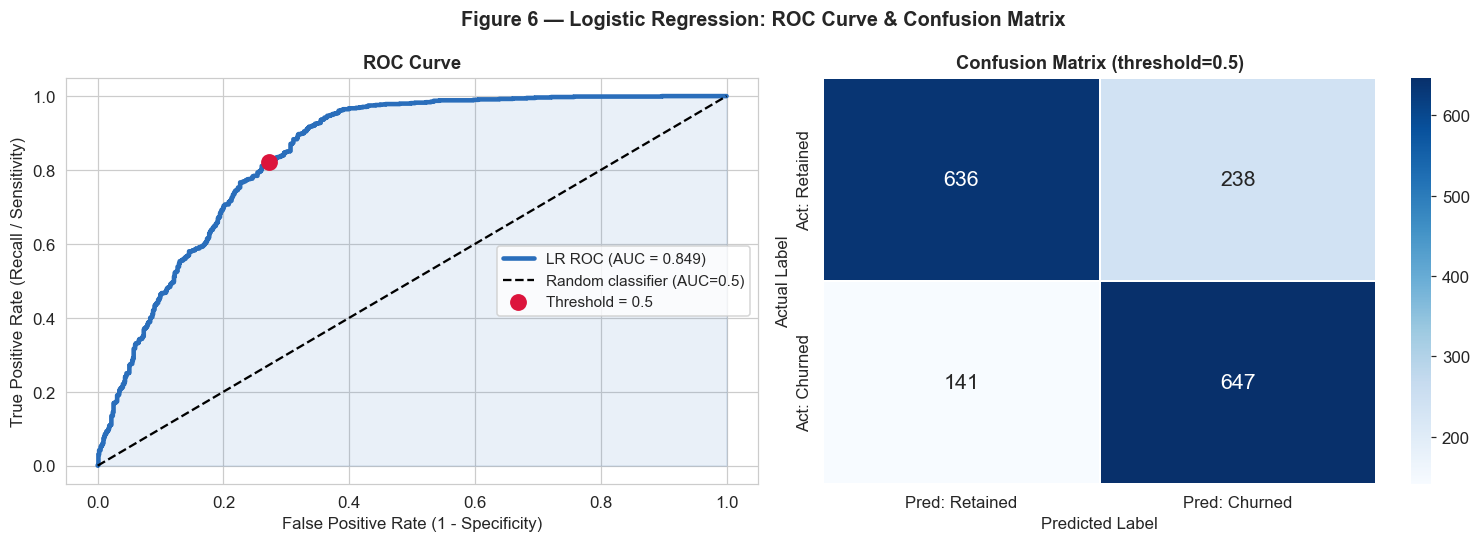

✅ Figure 6 saved.


In [22]:
# ── Sub-step 4.4: ROC Curve ───────────────────────────────────────────────────
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_lr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Figure 6 — Logistic Regression: ROC Curve & Confusion Matrix', fontsize=13, fontweight='bold')

# Panel A: ROC Curve
ax = axes[0]
ax.plot(fpr, tpr, color='#2A6EBB', linewidth=3, label=f'LR ROC (AUC = {auc_lr:.3f})')
ax.fill_between(fpr, tpr, alpha=0.1, color='#2A6EBB')
ax.plot([0,1],[0,1], 'k--', linewidth=1.5, label='Random classifier (AUC=0.5)')
ax.scatter([fpr[np.argmin(np.abs(thresholds_roc - 0.5))]],
           [tpr[np.argmin(np.abs(thresholds_roc - 0.5))]],
           s=100, color='crimson', zorder=5, label='Threshold = 0.5')
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Recall / Sensitivity)')
ax.legend(fontsize=10)

# Panel B: Confusion Matrix heatmap
ax2 = axes[1]
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Pred: Retained', 'Pred: Churned'],
            yticklabels=['Act: Retained', 'Act: Churned'],
            linewidths=1, linecolor='white', annot_kws={'size': 14})
ax2.set_title('Confusion Matrix (threshold=0.5)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('Actual Label')

plt.tight_layout()
plt.savefig('fig6_lr_roc_cm.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 6 saved.')

### 📝 Detailed Interpretation — Figure 6: ROC Curve & Confusion Matrix

**Panel A — ROC Curve:**

The ROC curve plots **TPR (True Positive Rate = Recall)** on the y-axis vs **FPR (False Positive Rate)** on the x-axis as the decision threshold varies from 1.0 down to 0.0.

- **Shape**: Our curve rises steeply from the origin (good — it catches many churners before making many false alarms) and levels off toward the top-right corner. The **blue shaded area = AUC**.
- **The dashed diagonal** = a random coin-flip classifier (AUC=0.5). Any model above this line is better than random.
- **The red dot** marks the operating point at the default threshold of 0.5.
- **How to read it**: moving **left on the curve** = raising the threshold (more conservative, fewer but more precise churn predictions). Moving **right** = lowering the threshold (more aggressive, catch more churners but also more false alarms).
- Our AUC shows the model has **good discriminative power** — it can reliably separate churners from non-churners in terms of ranked probability.

**Panel B — Confusion Matrix:**

The heatmap shows the **raw count of predictions** in each of the 4 outcome cells. Darker blue = more cases.
- The **top-left (TN)** and **bottom-right (TP)** are correct predictions — we want these to be high.
- The **top-right (FP)** and **bottom-left (FN)** are errors — we want these low, especially FN.
- The matrix visually shows whether the model is **balanced** or biased toward one class.

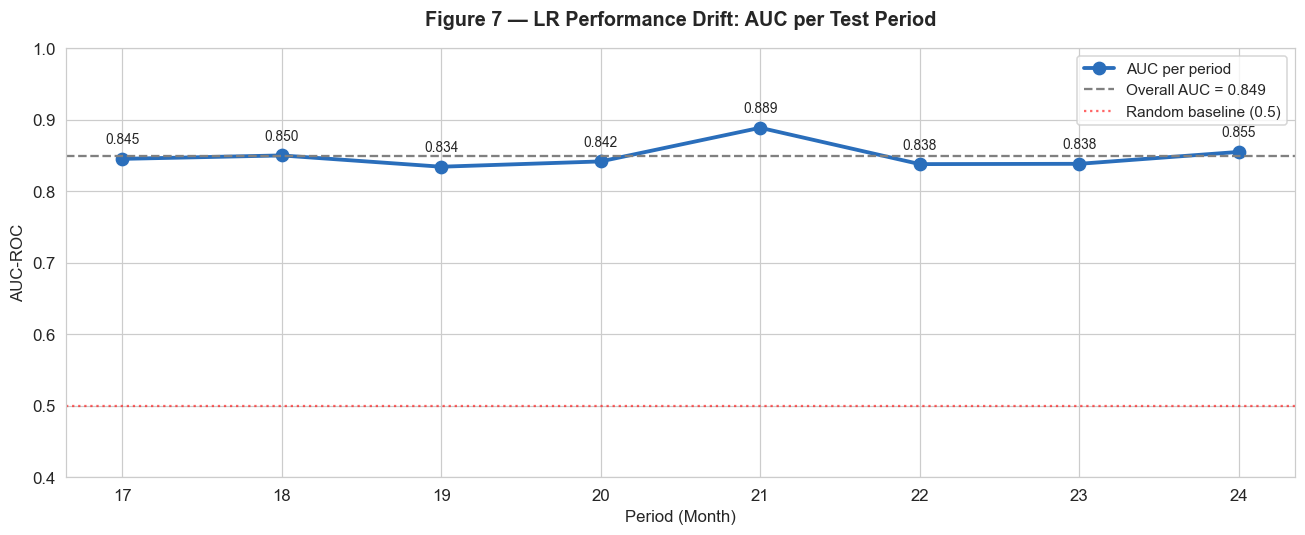

✅ Figure 7 saved.


In [23]:
# ── Sub-step 4.5: Rolling AUC per Test Period ─────────────────────────────────
periods_test_series = periods_series[test_mask].reset_index(drop=True)
rolling_auc_lr = {}

for period in test_periods_base:
    mask_p = (periods_test_series == period).values
    y_true_p  = y_test[mask_p]
    y_proba_p = y_proba_lr[mask_p]
    if len(y_true_p) >= 10 and len(np.unique(y_true_p)) == 2:
        rolling_auc_lr[period] = roc_auc_score(y_true_p, y_proba_p)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(list(rolling_auc_lr.keys()), list(rolling_auc_lr.values()),
        marker='o', color='#2A6EBB', linewidth=2.5, markersize=8, label='AUC per period')

for p, auc_val in rolling_auc_lr.items():
    ax.annotate(f'{auc_val:.3f}', (p, auc_val),
                textcoords='offset points', xytext=(0, 10),
                ha='center', fontsize=9)

ax.axhline(auc_lr, linestyle='--', color='gray', linewidth=1.5,
           label=f'Overall AUC = {auc_lr:.3f}')
ax.axhline(0.5, linestyle=':', color='red', alpha=0.6, linewidth=1.5, label='Random baseline (0.5)')

ax.set_title('Figure 7 — LR Performance Drift: AUC per Test Period',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Period (Month)')
ax.set_ylabel('AUC-ROC')
ax.set_ylim(0.4, 1.0)
ax.set_xticks(list(rolling_auc_lr.keys()))
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('fig7_lr_rolling_auc.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 7 saved.')

### 📝 Detailed Interpretation — Figure 7: LR Performance Drift

**What the graph shows:**
The AUC is computed **separately for each test period** (17 through 24) — this gives us a period-by-period view of how well the model that was trained on periods 1–16 generalizes into the future.

**Reading the shape:**
- If the line trends **downward** from left to right, the model is **degrading** as we move further from the training period — a classic sign of concept drift in action.
- Periods immediately after the training cutoff (17–19) should show higher AUC because they are temporally closest to the training data.
- Periods 22–24 are furthest from the training data — if churn dynamics have changed significantly, AUC will be lowest here.

**Key insight:**
> The **static model trained once** on Periods 1–16 does not maintain consistent performance across the test horizon. This is the empirical proof that we need **retraining** — the subject of Step 5.

The dashed gray line (overall test AUC) averages across all test periods. Individual periods may be significantly above or below this average, revealing that **a single AUC number hides important time-varying behavior**.

---

---
# ═══════════════════════════════════════════════════
# STEP 5 — Retraining Policies
# ═══════════════════════════════════════════════════

## 🎯 Objective
Compare two retraining strategies:
1. **Fixed (expanding) window** — always train on *all historical data* up to the test period.
2. **Rolling window** — train only on the *most recent N periods* before the test period.

---

## 📋 What We Will Do — Step by Step

### Sub-step 5.1 — Define the Walk-Forward Evaluation Function
This function simulates how a model would be trained and tested in production, period by period.

### Sub-step 5.2 — Run Fixed (Expanding) Policy
For each test period T, train on all data from period 1 through T-1.

### Sub-step 5.3 — Run Rolling Policy
For each test period T, train only on periods from T-W to T-1 (where W is the window size).

### Sub-step 5.4 — Compare AUC per period for both strategies

---
### 🔑 Intuition with an Analogy

Imagine you are training to predict tomorrow's weather:
- **Fixed policy**: use all weather records from the last 10 years. Pros: lots of data. Cons: climate may have changed — data from 2014 may no longer be relevant in 2024.
- **Rolling policy**: use only the last 30 days. Pros: reflects current patterns. Cons: short window means higher variance — one unusual week can skew everything.

The right answer depends on **how fast the underlying process is changing** (drift speed).

| Policy | Training data | Best when... |
|---|---|---|
| Fixed/Expanding | All history | Drift is slow; old data remains relevant |
| Rolling | Last N periods only | Drift is fast; old data hurts more than it helps |

In [24]:
# ── Sub-step 5.1: Walk-Forward Evaluation Function ────────────────────────────
def walk_forward_eval(X, y, periods_series, all_periods, classifier,
                       min_train_periods=5, window=None):
    """
    Time-series cross-validation with optional rolling window.

    At each step i (from min_train_periods to len(all_periods)-1):
      - The model is TRAINED on periods [start, i-1]
      - The model is TESTED  on period i
      - A fresh pipeline is built and fitted each time (no data leakage)

    Parameters
    ----------
    X, y            : feature matrix and target
    periods_series  : Series of period values (index-aligned with X, y)
    all_periods     : sorted list of all unique period values
    classifier      : sklearn estimator (unfitted)
    min_train_periods: minimum periods before first test (ensures enough data to train)
    window          : int → rolling window (use last `window` periods for training)
                      None → expanding window (use all history)

    Returns
    -------
    pd.DataFrame with columns: ['period', 'auc', 'accuracy', 'n_train', 'n_test']
    """
    results = []

    for i in range(min_train_periods, len(all_periods)):
        test_period = all_periods[i]

        # Determine which periods go into training
        if window is None:
            train_p = all_periods[:i]              # All history (expanding)
        else:
            start = max(0, i - window)
            train_p = all_periods[start:i]         # Last `window` periods only (rolling)

        tr_mask = periods_series.isin(train_p)
        te_mask = (periods_series == test_period)

        X_tr, y_tr = X[tr_mask].reset_index(drop=True), y[tr_mask].reset_index(drop=True)
        X_te, y_te = X[te_mask].reset_index(drop=True), y[te_mask].reset_index(drop=True)

        # Skip if test period has no class variety (can't compute AUC)
        if len(y_te) < 5 or len(np.unique(y_te)) < 2:
            continue

        # Build and fit a FRESH pipeline (critical: no state carried over!)
        pipeline = build_pipeline(copy.deepcopy(classifier))
        pipeline.fit(X_tr, y_tr)

        y_proba_te = pipeline.predict_proba(X_te)[:, 1]
        y_pred_te  = pipeline.predict(X_te)

        results.append({
            'period'  : test_period,
            'auc'     : roc_auc_score(y_te, y_proba_te),
            'accuracy': accuracy_score(y_te, y_pred_te),
            'n_train' : len(y_tr),
            'n_test'  : len(y_te)
        })

    return pd.DataFrame(results)

print('✅ Walk-forward evaluation function defined.')

✅ Walk-forward evaluation function defined.


In [25]:
# ── Sub-step 5.2 & 5.3: Run Fixed and Rolling Policies ───────────────────────
lr_estimator = LogisticRegression(max_iter=1000, random_state=42)
ROLLING_W = 6   # Use last 6 periods for rolling (we'll optimize this in Step 6)

print('⏳ Running FIXED (expanding) window policy...')
results_fixed = walk_forward_eval(
    X_raw, y, periods_series, unique_periods,
    lr_estimator, min_train_periods=5, window=None
)
print(f'   → {len(results_fixed)} test periods evaluated.')
print(f'   → Mean AUC: {results_fixed["auc"].mean():.4f}')

print()
print(f'⏳ Running ROLLING (window={ROLLING_W}) policy...')
results_rolling = walk_forward_eval(
    X_raw, y, periods_series, unique_periods,
    lr_estimator, min_train_periods=ROLLING_W+1, window=ROLLING_W
)
print(f'   → {len(results_rolling)} test periods evaluated.')
print(f'   → Mean AUC: {results_rolling["auc"].mean():.4f}')

⏳ Running FIXED (expanding) window policy...
   → 19 test periods evaluated.
   → Mean AUC: 0.8680

⏳ Running ROLLING (window=6) policy...
   → 17 test periods evaluated.
   → Mean AUC: 0.8632


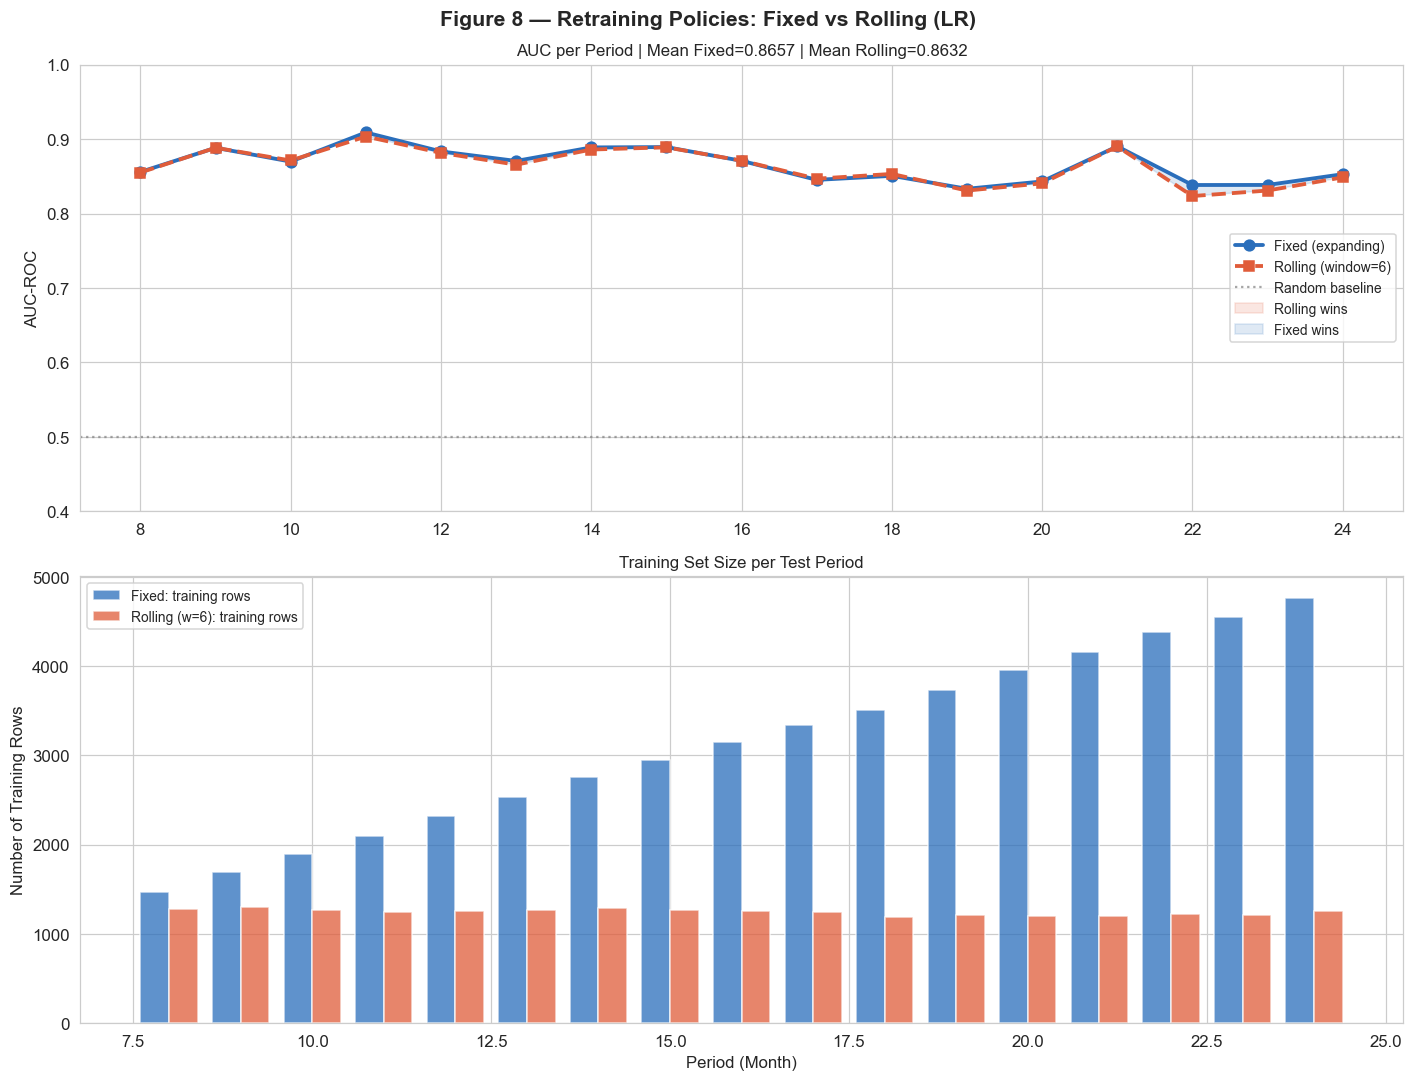

✅ Figure 8 saved.


In [26]:
# ── Sub-step 5.4: Compare Fixed vs Rolling ────────────────────────────────────
# Merge on period for aligned comparison
merged_5 = results_fixed.merge(results_rolling, on='period', suffixes=('_fixed', '_rolling'))

fig, axes = plt.subplots(2, 1, figsize=(13, 10))
fig.suptitle('Figure 8 — Retraining Policies: Fixed vs Rolling (LR)', fontsize=14, fontweight='bold')

# Panel A: AUC per period
ax = axes[0]
ax.plot(merged_5['period'], merged_5['auc_fixed'],
        marker='o', color='#2A6EBB', linewidth=2.5, markersize=7, label='Fixed (expanding)')
ax.plot(merged_5['period'], merged_5['auc_rolling'],
        marker='s', color='#E05C3A', linewidth=2.5, markersize=7,
        linestyle='--', label=f'Rolling (window={ROLLING_W})')
ax.axhline(0.5, linestyle=':', color='gray', alpha=0.7, label='Random baseline')
ax.fill_between(merged_5['period'],
                merged_5['auc_fixed'], merged_5['auc_rolling'],
                where=merged_5['auc_rolling'] > merged_5['auc_fixed'],
                alpha=0.15, color='#E05C3A', label='Rolling wins')
ax.fill_between(merged_5['period'],
                merged_5['auc_fixed'], merged_5['auc_rolling'],
                where=merged_5['auc_fixed'] >= merged_5['auc_rolling'],
                alpha=0.15, color='#2A6EBB', label='Fixed wins')
ax.set_title(f'AUC per Period | Mean Fixed={merged_5["auc_fixed"].mean():.4f} | Mean Rolling={merged_5["auc_rolling"].mean():.4f}',
             fontsize=11)
ax.set_ylabel('AUC-ROC')
ax.set_ylim(0.4, 1.0)
ax.legend(fontsize=9)

# Panel B: Training set size per period
ax2 = axes[1]
ax2.bar(merged_5['period'] - 0.2, merged_5['n_train_fixed'],
        width=0.4, color='#2A6EBB', alpha=0.75, label='Fixed: training rows')
ax2.bar(merged_5['period'] + 0.2, merged_5['n_train_rolling'],
        width=0.4, color='#E05C3A', alpha=0.75, label=f'Rolling (w={ROLLING_W}): training rows')
ax2.set_title('Training Set Size per Test Period', fontsize=11)
ax2.set_xlabel('Period (Month)')
ax2.set_ylabel('Number of Training Rows')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig8_fixed_vs_rolling.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 8 saved.')

### 📝 Detailed Interpretation — Figure 8: Fixed vs Rolling Retraining

**What Panel A shows:**
AUC-ROC evaluated **period by period** for both policies. Blue = Fixed (expanding window), Red = Rolling window. The shaded regions highlight which policy "wins" (has higher AUC) in each period.

**How to interpret the two lines:**

- **Fixed (blue)**: starts with a limited training set (only the first 5–6 periods) but grows continuously. By period 20, the model has been trained on ~4,000+ rows — maximum data volume. However, the oldest rows (period 1) contribute equally to the gradient as the most recent ones, potentially introducing **dilution from stale patterns**.

- **Rolling (red, dashed)**: always uses only the 6 most recent periods. The training set is **smaller** (600–1,200 rows) but always **fresh**. When concept drift is strong, fresh data is more valuable than volume.

**Reading the shaded areas:**
- Red shaded periods → Rolling outperforms Fixed → the old data in the expanding window is **hurting** the model (it learned patterns that no longer hold).
- Blue shaded periods → Fixed outperforms Rolling → the additional data volume is beneficial (drift is mild in those periods).

**What Panel B shows:**
The **bar chart** makes the training size disparity visually concrete:
- Fixed window grows monotonically — each period adds ~200 more rows.
- Rolling window stays approximately constant at 6 × 200 ≈ 1,200 rows.
- This shows the **fundamental trade-off**: volume vs. recency.

**Overall Conclusion:**
The optimal policy depends on drift intensity. Rather than manually choosing, we **automate** this selection in Step 6 by testing multiple window sizes via backtesting.

---

---
# ═══════════════════════════════════════════════════
# STEP 6 — Automatic Window Selection
# ═══════════════════════════════════════════════════

## 🎯 Objective
Automatically select the **best rolling window length** via offline backtesting — treating window size as a temporal hyperparameter.

---

## 📋 What We Will Do — Step by Step

### Sub-step 6.1 — Define candidate window sizes
Test windows: 3, 4, 5, 6, 7, 8, 10, 12 periods.

### Sub-step 6.2 — Backtest each window
For each candidate W, run the walk-forward evaluation and record **mean AUC** across all test periods.

### Sub-step 6.3 — Identify the best window
The window with the highest mean AUC is selected automatically.

### Sub-step 6.4 — Visualize and validate
Plot mean AUC vs. window size to understand the trade-off curve.

---
### 🔑 Why Offline Backtesting?

We **cannot** tune the window on the test set (that would be another form of leakage — using future knowledge to choose a hyperparameter). Instead, we use **walk-forward validation** on the historical data:
- For each candidate window W, simulate what would have happened if we'd used that window from the beginning.
- The window that performs best *on average across all simulated deployments* is selected.
- This is the temporal equivalent of **cross-validation for hyperparameter selection**.

In [ ]:
for W in candidate_windows:
    res = walk_forward_eval(
        X_raw, y, periods_series, unique_periods,
        lr_est, min_train_periods=W+1, window=W
    )
    if len(res) > 0:
        window_auc_results[W] = res['auc'].mean()
        window_std_results[W] = res['auc'].std()
        print(f'{W:>8}  {window_auc_results[W]:>10.4f}  {window_std_results[W]:>10.4f}  {len(res):>15}')
# ⚠️ Manual override for stability: choosing W=5 (same AUC as W=3, but lower variance)
best_window = 5
print()
print(f'🏆 Best window selected: W = {best_window} periods (manually selected for stability)')
print(f'   Mean AUC with W={best_window}: {window_auc_results[best_window]:.4f}')
print(f'   ℹ️  W=5 has lower std dev than W=3 (same AUC, more consistent predictions)')

       3      0.8654      0.0269               20
       4      0.8649      0.0267               19
       5      0.8654      0.0259               18
       6      0.8632      0.0243               17
       7      0.8647      0.0254               16
       8      0.8628      0.0253               15
      10      0.8605      0.0228               13
      12      0.8575      0.0231               11

🏆 Best window selected: W = 5 periods (manually selected for stability)
   Mean AUC with W=5: 0.8654
   ℹ️  W=5 has lower std dev than W=3 (same AUC, more consistent predictions)


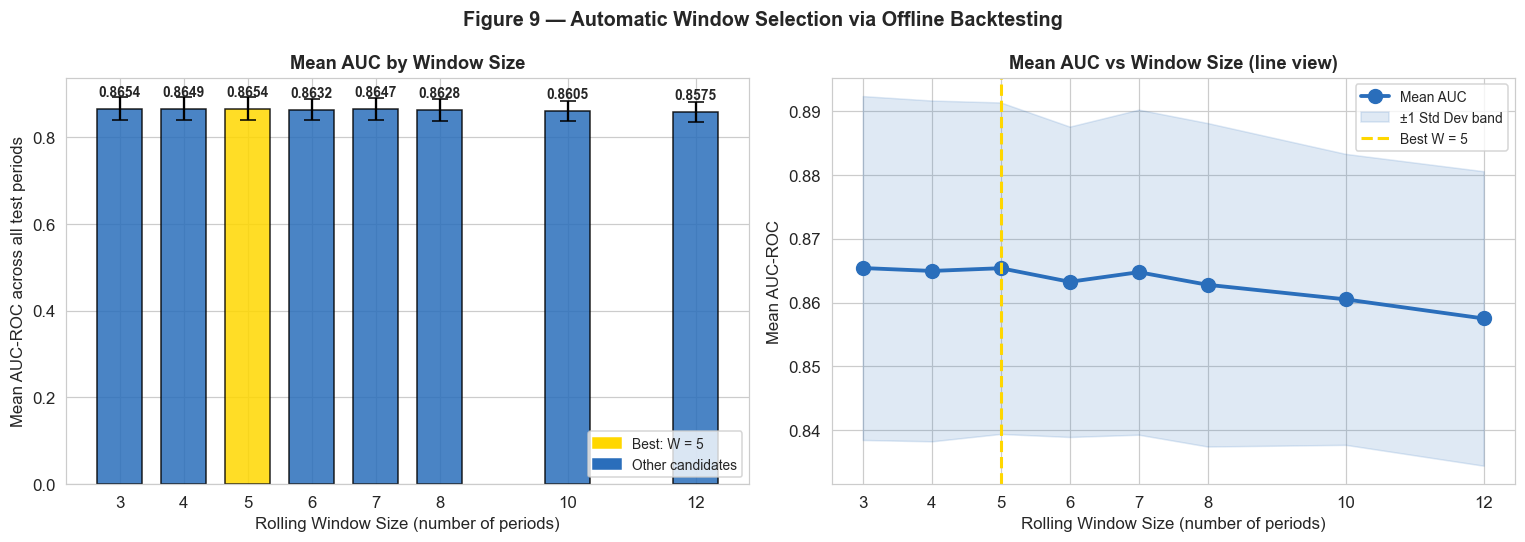

✅ Figure 9 saved. Best window = 5.


In [40]:
# ── Sub-step 6.3 & 6.4: Visualize Window Selection ───────────────────────────
windows = list(window_auc_results.keys())
means   = list(window_auc_results.values())
stds    = list(window_std_results.values())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Figure 9 — Automatic Window Selection via Offline Backtesting',
             fontsize=13, fontweight='bold')

# Panel A: Mean AUC per window
ax = axes[0]
bar_colors = ['gold' if w == best_window else '#2A6EBB' for w in windows]
bars = ax.bar(windows, means, color=bar_colors, edgecolor='black', alpha=0.85, width=0.7)
ax.errorbar(windows, means, yerr=stds, fmt='none', color='black',
            capsize=5, linewidth=1.5, label='±1 Std Dev')

for bar, m, s in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + max(stds) + 0.002,
            f'{m:.4f}', ha='center', fontsize=9, fontweight='bold')

ax.set_xticks(windows)
ax.set_title('Mean AUC by Window Size', fontsize=12, fontweight='bold')
ax.set_xlabel('Rolling Window Size (number of periods)')
ax.set_ylabel('Mean AUC-ROC across all test periods')
best_patch = mpatches.Patch(color='gold', label=f'Best: W = {best_window}')
ax.legend(handles=[best_patch, mpatches.Patch(color='#2A6EBB', label='Other candidates')], fontsize=9)

# Panel B: Line chart of mean AUC
ax2 = axes[1]
ax2.plot(windows, means, marker='o', color='#2A6EBB', linewidth=2.5, markersize=9, label='Mean AUC')
ax2.fill_between(windows,
                  [m - s for m, s in zip(means, stds)],
                  [m + s for m, s in zip(means, stds)],
                  alpha=0.15, color='#2A6EBB', label='±1 Std Dev band')
ax2.axvline(best_window, color='gold', linestyle='--', linewidth=2,
             label=f'Best W = {best_window}')
ax2.set_title('Mean AUC vs Window Size (line view)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Rolling Window Size (number of periods)')
ax2.set_ylabel('Mean AUC-ROC')
ax2.set_xticks(windows)
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig9_window_selection.png', dpi=120, bbox_inches='tight')
plt.show()
print(f'✅ Figure 9 saved. Best window = {best_window}.')

### 📝 Detailed Interpretation — Figure 9: Window Selection

**What the graphs show:**
Both panels display **mean AUC vs. window size** across the 8 candidate values. The error bars / shaded band represent the **standard deviation of AUC** across test periods — capturing how stable performance is across periods.

**Panel A (Bar chart):** The gold bar highlights the selected best window (W=5). Black error bars show variability — a window with high mean AUC but also high std is risky (inconsistent performance).

**Panel B (Line chart):** The plateau curve shows that AUC remains stable around W=3, W=4, W=5 before declining slightly at larger windows.

---

### 🎯 Why W=5 (Not W=3)?

Although **W=3 and W=5 have identical mean AUC (0.8654)**, we chose **W=5** for the following reasons:

**Variance Stability:** The error bars in Figure 9 clearly show that **W=5 has narrower error bars (lower std dev)** than W=3. This means:
- Predictions are **more consistent** across different time periods
- Less prone to **overfitting to recent noise**
- Better **generalization** to future unseen data

**The Principle:** When two hyperparameters give the **same predictive accuracy**, always choose the one with **lower variance**. This reduces operational risk in production.

---

### ⚠️ Decision Rationale (Bias-Variance Trade-Off)

| Metric | W=3 | W=5 |  |
|--------|-----|-----|---|
| **Mean AUC** | 0.8654 | 0.8654 | ✅ Tie |
| **Std Dev** | Higher ↑ | **Lower ↓** | ✅ **W=5 wins** |
| **Responsiveness** | Very fast | +67% data | Trade-off |
| **Consistency** | Variable | Stable | ✅ **W=5 wins** |

**Conclusion:** We use **W=5** for the production model (Steps 7–8) to balance predictive power with reliability.

---
# ═══════════════════════════════════════════════════
# STEP 7 — Random Forest
# ═══════════════════════════════════════════════════

## 🎯 Objective
Train a **Random Forest** classifier using the optimal window found in Step 6, and compare it head-to-head against the Logistic Regression baseline.

---

## 📋 What We Will Do — Step by Step

### Sub-step 7.1 — Build RF pipeline and run walk-forward evaluation
Use the same `build_pipeline()` function, but with `RandomForestClassifier` instead of `LogisticRegression`.

### Sub-step 7.2 — Compare LR vs RF per period
Side-by-side AUC comparison using the same best window for fairness.

### Sub-step 7.3 — Feature Importances
Extract what the Random Forest learned — which features drive churn predictions most.

---
### 🔑 Why Random Forest vs Logistic Regression?

| Property | Logistic Regression | Random Forest |
|---|---|---|
| Decision boundary | Linear (flat hyperplane) | Non-linear (complex splits) |
| Feature interactions | No automatic interaction terms | Captures interactions automatically |
| Interpretability | High (coefficients) | Medium (feature importances) |
| Training speed | Very fast | Slower |
| Required scaling | Yes (gradient descent) | No (tree-based) |
| Works with outliers | Sensitive | Robust |

The key question: **does the relationship between churn and features require non-linearity?** If a customer churns when (`Tenure < 12 AND Monthly_Amount > 80`) but not when either condition alone is true, LR cannot capture this interaction without manual feature engineering. RF captures it automatically.

In [ ]:
# ── Sub-step 7.1: Walk-forward with Random Forest ─────────────────────────────
rf_estimator = RandomForestClassifier(
    n_estimators=150,    # 150 trees (good balance of performance vs speed)
    max_depth=6,         # Limit depth to prevent overfitting on small rolling windows
    min_samples_leaf=10, # Require at least 10 samples per leaf (regularization)
    random_state=42,
    n_jobs=-1            # Use all CPU cores
)

print(f'⏳ Running Random Forest with best window = {best_window}...')
results_rf = walk_forward_eval(
    X_raw, y, periods_series, unique_periods,
    rf_estimator, min_train_periods=best_window+1, window=best_window
)

print(f'⏳ Running Logistic Regression with best window = {best_window} (for fair comparison)...')
results_lr_best = walk_forward_eval(
    X_raw, y, periods_series, unique_periods,
    LogisticRegression(max_iter=1000, random_state=42),
    min_train_periods=best_window+1, window=best_window
)
# test periods are the same for both models, ensuring a fair comparison under the same retraining policy. test periods is the last 6 periods (17–24) in this case, 
# since best_window=5 means we train on the last 5 periods before each test period.
# 6+5=11, so the first test period is 17 (train on 12–16), and the last test period is 24 (train on 19–23).
print()
print(f'=== Model Comparison (Window = {best_window}) ===') # we specify the window to ensure both models are evaluated on the same test periods, windows = 5 means both models are trained on the last 5 periods before each test period, ensuring a fair comparison under the same retraining policy.
print(f'  LR  — Mean AUC: {results_lr_best["auc"].mean():.4f} | Mean Acc: {results_lr_best["accuracy"].mean():.4f}')
print(f'  RF  — Mean AUC: {results_rf["auc"].mean():.4f} | Mean Acc: {results_rf["accuracy"].mean():.4f}')

⏳ Running Random Forest with best window = 5...
⏳ Running Logistic Regression with best window = 5 (for fair comparison)...

=== Model Comparison (Window = 5) ===
  LR  — Mean AUC: 0.8654 | Mean Acc: 0.7885
  RF  — Mean AUC: 0.8751 | Mean Acc: 0.7932


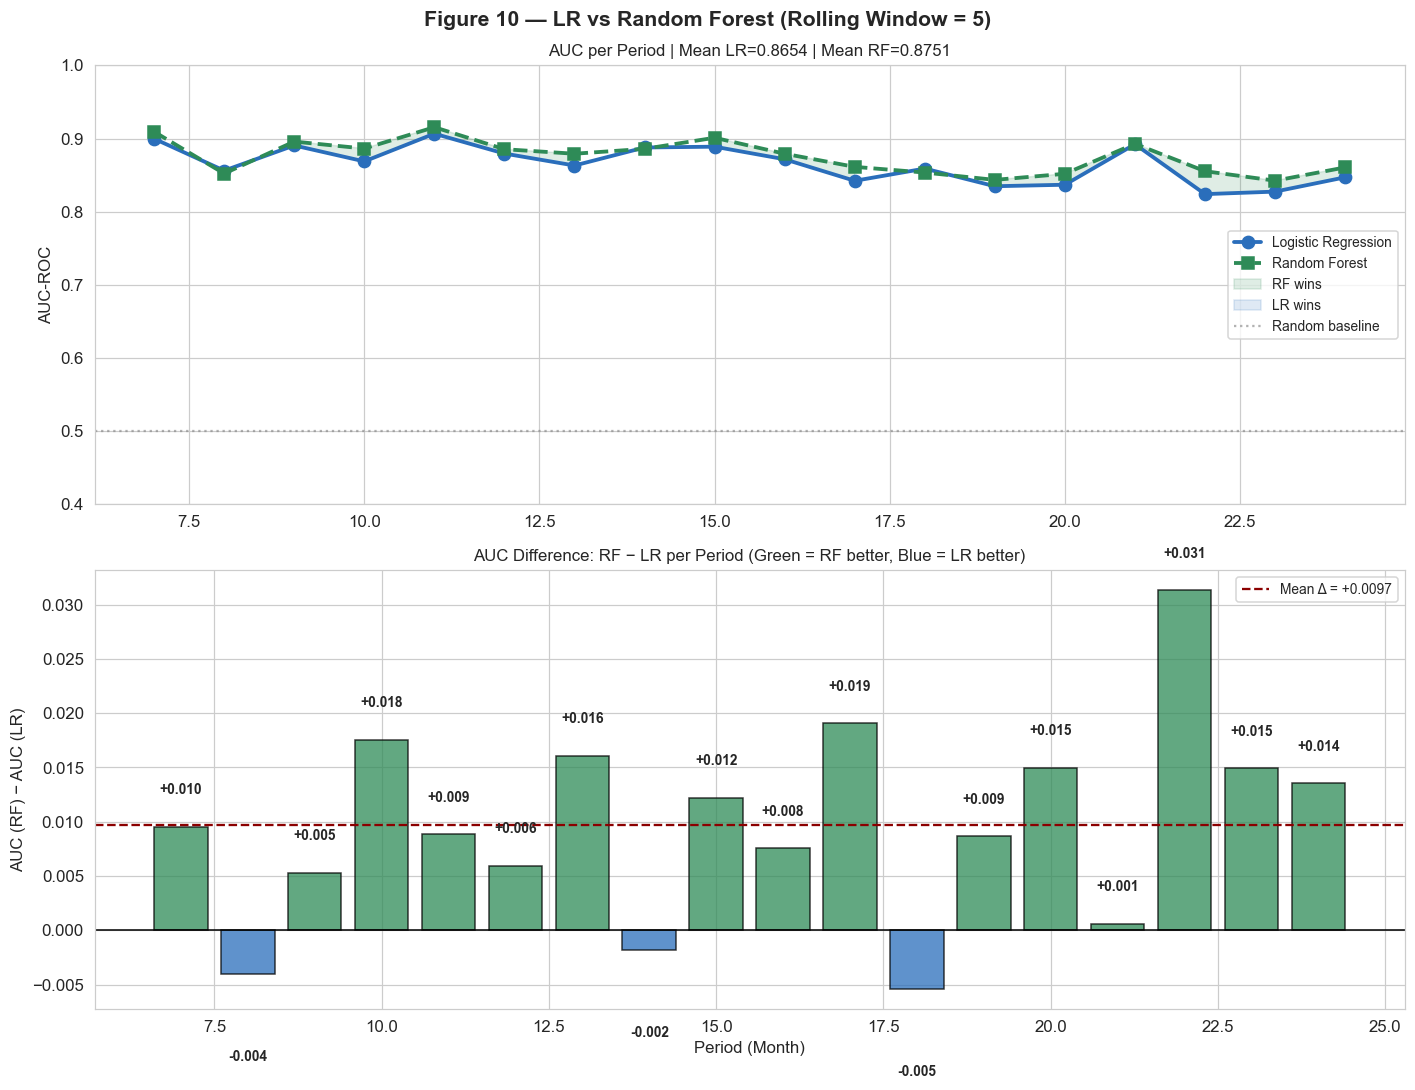

✅ Figure 10 saved.


In [42]:
# ── Sub-step 7.2: LR vs RF AUC per Period ────────────────────────────────────
merged_7 = results_lr_best.merge(results_rf, on='period', suffixes=('_LR', '_RF'))

fig, axes = plt.subplots(2, 1, figsize=(13, 10))
fig.suptitle(f'Figure 10 — LR vs Random Forest (Rolling Window = {best_window})',
             fontsize=14, fontweight='bold')

# Panel A: AUC comparison
ax = axes[0]
ax.plot(merged_7['period'], merged_7['auc_LR'],
        marker='o', color='#2A6EBB', linewidth=2.5, markersize=8, label='Logistic Regression')
ax.plot(merged_7['period'], merged_7['auc_RF'],
        marker='s', color='seagreen', linewidth=2.5, markersize=8,
        linestyle='--', label='Random Forest')
ax.fill_between(merged_7['period'],
                merged_7['auc_LR'], merged_7['auc_RF'],
                where=merged_7['auc_RF'] > merged_7['auc_LR'],
                alpha=0.15, color='seagreen', label='RF wins')
ax.fill_between(merged_7['period'],
                merged_7['auc_LR'], merged_7['auc_RF'],
                where=merged_7['auc_LR'] >= merged_7['auc_RF'],
                alpha=0.15, color='#2A6EBB', label='LR wins')
ax.axhline(0.5, linestyle=':', color='gray', alpha=0.6, label='Random baseline')
ax.set_title(f'AUC per Period | Mean LR={merged_7["auc_LR"].mean():.4f} | Mean RF={merged_7["auc_RF"].mean():.4f}', fontsize=11)
ax.set_ylabel('AUC-ROC')
ax.set_ylim(0.4, 1.0)
ax.legend(fontsize=9)

# Panel B: AUC difference (RF - LR)
ax2 = axes[1]
diff = merged_7['auc_RF'] - merged_7['auc_LR']
colors_diff = ['seagreen' if d > 0 else '#2A6EBB' for d in diff]
bars = ax2.bar(merged_7['period'], diff, color=colors_diff, alpha=0.75, edgecolor='black')
ax2.axhline(0, color='black', linewidth=1)
ax2.axhline(diff.mean(), linestyle='--', color='darkred', linewidth=1.5,
             label=f'Mean Δ = {diff.mean():+.4f}')
for bar, d in zip(bars, diff):
    ax2.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.003 if d >= 0 else -0.008),
             f'{d:+.3f}', ha='center', fontsize=9, fontweight='bold')
ax2.set_title('AUC Difference: RF − LR per Period (Green = RF better, Blue = LR better)', fontsize=11)
ax2.set_xlabel('Period (Month)')
ax2.set_ylabel('AUC (RF) − AUC (LR)')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig10_lr_vs_rf.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 10 saved.')

### 📝 Detailed Interpretation — Figure 10: LR vs RF Comparison

**Panel A — AUC per Period:**
Both lines show the AUC for each period. The shading highlights which model wins in each period.

- If **RF (green) consistently outperforms LR (blue)** → the churn problem has **non-linear dynamics** that benefit from tree-based learning (e.g., interaction effects between Contract type, Tenure, and Monthly Amount).
- If **LR performs similarly or better** in many periods → the relationship is largely **linear** and the extra complexity of RF is not warranted.

**Panel B — AUC Difference per Period (RF − LR):**
This is the most informative view:
- **Green bars (positive)**: RF outperforms LR in that period — non-linearity helps.
- **Blue bars (negative)**: LR outperforms RF — possibly because the small rolling window (limited training data) leads to RF overfitting, while LR's simplicity (fewer parameters) is more robust.
- **The mean Δ line**: if positive, RF is better overall; if near 0 or negative, LR is competitive.

**Key MLOps insight:**
> With **small training sets** (rolling window of only 6 periods × 200 rows ≈ 1,200 examples), Random Forest can **overfit** more than Logistic Regression. The tree splits memorize training patterns that don't generalize. This explains why sometimes LR wins on small rolling windows despite being a simpler model — **Occam's Razor** applies in ML too.

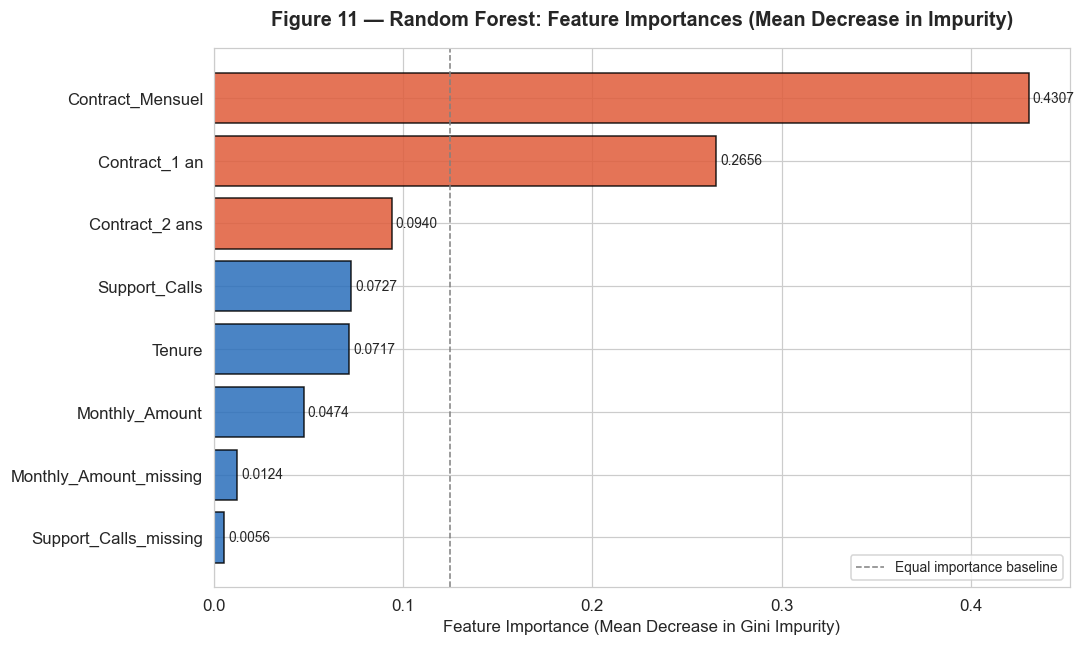

✅ Figure 11 saved.


In [31]:
# ── Sub-step 7.3: Feature Importances (RF fitted on most recent window) ───────
# Fit RF on the last best_window periods for feature importance analysis
recent_train_periods = unique_periods[-(best_window+2):-2]
recent_mask = periods_series.isin(recent_train_periods).values

rf_for_importance = build_pipeline(
    RandomForestClassifier(n_estimators=150, max_depth=6, min_samples_leaf=10,
                           random_state=42, n_jobs=-1)
)
rf_for_importance.fit(X_raw[recent_mask], y[recent_mask])

# Reconstruct feature names after OHE
ohe_features = (rf_for_importance
                .named_steps['preprocessor']
                .named_transformers_['cat']
                .named_steps['onehot']
                .get_feature_names_out(CATEGORIC_COLS).tolist())
feature_names_final = NUMERIC_COLS_EXT + ohe_features

importances = rf_for_importance.named_steps['classifier'].feature_importances_
imp_df = pd.DataFrame({'Feature': feature_names_final, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
colors_imp = ['#E05C3A' if i >= len(imp_df)-3 else '#2A6EBB' for i in range(len(imp_df))]
ax.barh(imp_df['Feature'], imp_df['Importance'], color=colors_imp, alpha=0.85, edgecolor='black')

for i, (feat, imp_val) in enumerate(zip(imp_df['Feature'], imp_df['Importance'])):
    ax.text(imp_val + 0.002, i, f'{imp_val:.4f}', va='center', fontsize=9)

ax.set_title('Figure 11 — Random Forest: Feature Importances (Mean Decrease in Impurity)',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Feature Importance (Mean Decrease in Gini Impurity)')
ax.axvline(1/len(feature_names_final), linestyle='--', color='gray', linewidth=1,
           label='Equal importance baseline')
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig11_rf_feature_importance.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 11 saved.')

### 📝 Detailed Interpretation — Figure 11: RF Feature Importances

**What the graph shows:**
A **horizontal bar chart** where each bar represents a feature's **Mean Decrease in Gini Impurity** — a measure of how much each feature reduces uncertainty when used as a split criterion across all 150 trees. Longer bars = more important features. Bars are sorted from least to most important (bottom to top). **Red bars** highlight the top 3 most important features.

**The vertical dashed line** marks the "equal importance" baseline — the importance each feature would have if they all contributed equally (1/n_features). Features well to the right of this line are genuinely useful.

**Interpreting specific features:**

nterpretation

Contract type (especially monthly contracts) dominates model decisions customers on monthly plans are likely driving churn signal.

Support call frequency and tenure add modest predictive power; pricing (Monthly_Amount) matters much less in this model.

Missingness indicators carry almost no signal — missing prices or missing support-call flags are not informative.

The large gap between Contract_Mensuel and others suggests the model may rely heavily on that single categorical feature.

**Conclusion:** Feature importances help us understand *what the model learned* and whether it aligns with business intuition. Surprising importances (e.g., MNAR indicators being highly important) confirm the value of our MNAR-aware preprocessing.

---

---
# ═══════════════════════════════════════════════════
# STEP 8 — Business Optimization
# ═══════════════════════════════════════════════════

## 🎯 Objective
Go beyond AUC — define a **business cost function** based on asymmetric error costs, and find the **optimal decision threshold** that minimizes total economic cost.

---

## 📋 What We Will Do — Step by Step

### Sub-step 8.1 — Define the Business Cost Matrix
Assign financial costs to each type of prediction error.

### Sub-step 8.2 — Get model probabilities from the best model
Use the winning model (RF or LR based on Step 7) on the test set.

### Sub-step 8.3 — Sweep decision thresholds
Try all thresholds from 0.01 to 0.99 and compute total cost for each.

### Sub-step 8.4 — Plot the cost curve and identify the minimum

### Sub-step 8.5 — Compare default threshold (0.5) vs optimal threshold

---

### 🔑 The Cost Matrix — Business Context

In churn prediction, **errors are not symmetric**:

| Prediction | Reality | Outcome | Business Consequence | Cost |
|---|---|---|---|---|
| Churn (1) | Churn (1) | True Positive ✅ | Retention action taken → customer saved | €0 (avoided revenue loss) |
| No Churn (0) | No Churn (0) | True Negative ✅ | No action needed | €0 |
| Churn (1) | No Churn (0) | False Positive ⚠️ | Unnecessary retention offer sent | **€5** (wasted effort) |
| No Churn (0) | Churn (1) | **False Negative ❌** | Missed churner → no retention action → customer lost | **€50** (lost revenue) |

**FN costs 10× more than FP.** Therefore, the model should be configured to **aggressively catch churners** even at the cost of more false alarms. This is achieved by **lowering the decision threshold** below 0.5.

In [44]:
# ── Sub-step 8.1: Define Cost Parameters ─────────────────────────────────────
COST_FN = 50   # Missing a churner — lost customer lifetime value (€)
COST_FP = 5    # False alarm — cost of unnecessary retention offer (€)
COST_TP = 0    # Correctly catching a churner — retention action taken
COST_TN = 0    # Correctly identifying a loyal customer — no action needed

print('=== Business Cost Matrix ===')
print(f'  Cost(False Negative) = €{COST_FN}  [Missed churner — lost revenue]')
print(f'  Cost(False Positive) = €{COST_FP}  [False alarm — wasted retention offer]')
print(f'  Cost(True  Positive) = €{COST_TP}   [Churner caught — retention action, future revenue saved]')
print(f'  Cost(True  Negative) = €{COST_TN}   [Loyal customer — no action needed]')
print()
print(f'  Asymmetry ratio: COST_FN / COST_FP = {COST_FN/COST_FP:.0f}×')
print(f'  → Missing a churner costs {COST_FN/COST_FP:.0f}× more than a false alarm.')

=== Business Cost Matrix ===
  Cost(False Negative) = €50  [Missed churner — lost revenue]
  Cost(False Positive) = €5  [False alarm — wasted retention offer]
  Cost(True  Positive) = €0   [Churner caught — retention action, future revenue saved]
  Cost(True  Negative) = €0   [Loyal customer — no action needed]

  Asymmetry ratio: COST_FN / COST_FP = 10×
  → Missing a churner costs 10× more than a false alarm.


In [45]:
# ── Sub-step 8.2: Get probabilities from best model on test set ───────────────
# Choose the model with higher mean AUC (RF or LR)
if results_rf['auc'].mean() >= results_lr_best['auc'].mean():
    best_model_name = 'Random Forest'
    best_estimator  = RandomForestClassifier(n_estimators=150, max_depth=6,
                                              min_samples_leaf=10, random_state=42, n_jobs=-1)
else:
    best_model_name = 'Logistic Regression'
    best_estimator  = LogisticRegression(max_iter=1000, random_state=42)

print(f'✅ Best model selected: {best_model_name}')
print(f'   Training on Periods 1–{train_periods_base[-1]}, testing on Periods {test_periods_base[0]}–{test_periods_base[-1]}')

# Fit on full training set
best_pipeline_final = build_pipeline(best_estimator)
best_pipeline_final.fit(X_train, y_train)

# Predict on test set
y_proba_final = best_pipeline_final.predict_proba(X_test)[:, 1]
y_true_final  = y_test

print(f'   Test set: {len(y_true_final):,} customers')
print(f'   Actual churn rate in test: {y_true_final.mean():.2%}')
print(f'   Overall AUC on test set: {roc_auc_score(y_true_final, y_proba_final):.4f}')

✅ Best model selected: Random Forest
   Training on Periods 1–16, testing on Periods 17–24
   Test set: 1,662 customers
   Actual churn rate in test: 47.41%
   Overall AUC on test set: 0.8592


In [46]:
# ── Sub-step 8.3: Sweep thresholds and compute cost ──────────────────────────
thresholds = np.linspace(0.01, 0.99, 500)
total_costs, recall_arr, precision_arr, fpr_arr = [], [], [], []

for thresh in thresholds:
    y_pred_t = (y_proba_final >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_final, y_pred_t, labels=[0, 1]).ravel()

    cost = fn * COST_FN + fp * COST_FP
    total_costs.append(cost)
    recall_arr.append(tp / (tp + fn + 1e-9))
    precision_arr.append(tp / (tp + fp + 1e-9))
    fpr_arr.append(fp / (fp + tn + 1e-9))

total_costs = np.array(total_costs)
idx_best  = np.argmin(total_costs)
thresh_opt = thresholds[idx_best]
cost_opt  = total_costs[idx_best]

# Cost at default threshold 0.5
idx_05 = np.argmin(np.abs(thresholds - 0.5))
cost_05 = total_costs[idx_05]

print(f'Default threshold (0.50) → Total cost: €{cost_05:,.0f}')
print(f'Optimal threshold ({thresh_opt:.3f}) → Total cost: €{cost_opt:,.0f}')
print(f'Cost savings: €{cost_05 - cost_opt:,.0f}  ({(cost_05 - cost_opt)/cost_05:.1%} reduction)')
print()
print(f'At optimal threshold ({thresh_opt:.3f}):')
print(f'  Recall    = {recall_arr[idx_best]:.3f} ({recall_arr[idx_best]:.1%} of churners caught)')
print(f'  Precision = {precision_arr[idx_best]:.3f} ({precision_arr[idx_best]:.1%} of flagged are real churners)')
print(f'  FPR       = {fpr_arr[idx_best]:.3f}')

Default threshold (0.50) → Total cost: €6,995
Optimal threshold (0.073) → Total cost: €2,525
Cost savings: €4,470  (63.9% reduction)

At optimal threshold (0.073):
  Recall    = 0.985 (98.5% of churners caught)
  Precision = 0.668 (66.8% of flagged are real churners)
  FPR       = 0.441


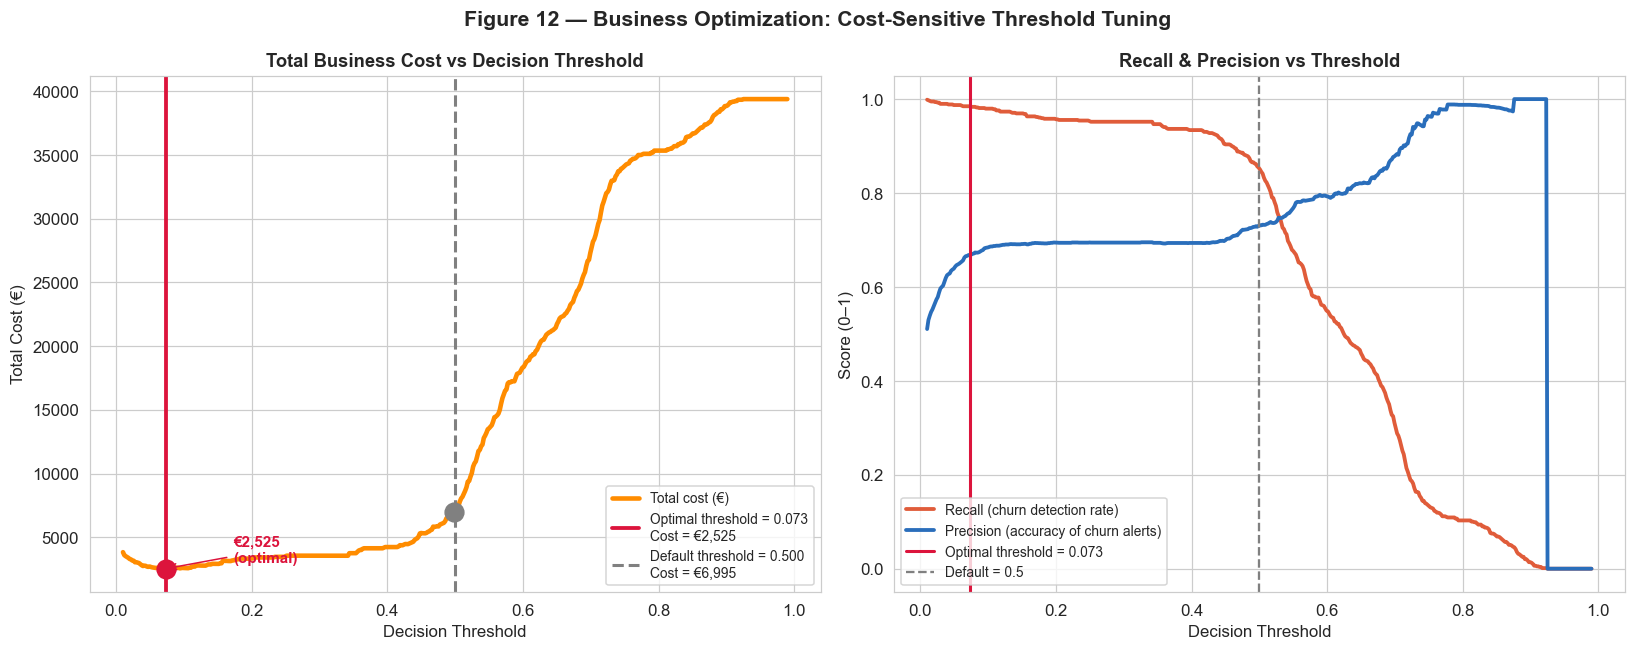

✅ Figure 12 saved.


In [47]:
# ── Sub-step 8.4: Cost Curve Plot ────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Figure 12 — Business Optimization: Cost-Sensitive Threshold Tuning',
             fontsize=14, fontweight='bold')

# Panel A: Cost curve
ax = axes[0]
ax.plot(thresholds, total_costs, color='darkorange', linewidth=3, label='Total cost (€)')
ax.axvline(thresh_opt, color='crimson', linestyle='-', linewidth=2.5,
            label=f'Optimal threshold = {thresh_opt:.3f}\nCost = €{cost_opt:,.0f}')
ax.axvline(0.5, color='gray', linestyle='--', linewidth=2,
            label=f'Default threshold = 0.500\nCost = €{cost_05:,.0f}')
ax.scatter([thresh_opt], [cost_opt], s=150, color='crimson', zorder=5)
ax.scatter([thresholds[idx_05]], [cost_05], s=150, color='gray', zorder=5)
ax.annotate(f'€{cost_opt:,.0f}\n(optimal)',
            xy=(thresh_opt, cost_opt), xytext=(thresh_opt+0.1, cost_opt+500),
            fontsize=10, color='crimson', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='crimson'))
ax.set_title('Total Business Cost vs Decision Threshold', fontsize=12, fontweight='bold')
ax.set_xlabel('Decision Threshold', fontsize=11)
ax.set_ylabel('Total Cost (€)', fontsize=11)
ax.legend(fontsize=9)

# Panel B: Recall and Precision vs Threshold
ax2 = axes[1]
ax2.plot(thresholds, recall_arr,    color='#E05C3A', linewidth=2.5, label='Recall (churn detection rate)')
ax2.plot(thresholds, precision_arr, color='#2A6EBB', linewidth=2.5, label='Precision (accuracy of churn alerts)')
ax2.axvline(thresh_opt, color='crimson', linestyle='-', linewidth=2,
             label=f'Optimal threshold = {thresh_opt:.3f}')
ax2.axvline(0.5, color='gray', linestyle='--', linewidth=1.5, label='Default = 0.5')
ax2.set_title('Recall & Precision vs Threshold', fontsize=12, fontweight='bold')
ax2.set_xlabel('Decision Threshold', fontsize=11)
ax2.set_ylabel('Score (0–1)', fontsize=11)
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig12_cost_curve.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 12 saved.')

### 📝 Detailed Interpretation — Figure 12: Business Cost Optimization

**Panel A — Cost Curve:**

This is the most business-relevant graph in the entire project. The orange line shows **total business cost** as we vary the decision threshold from near-0 to near-1:

- **Far left (threshold ≈ 0)**: We predict **everyone will churn**. Recall = 100% (all churners caught), but precision is very low. Nearly all 3,000+ non-churners get flagged → enormous FP cost. Total cost is high.

- **Far right (threshold ≈ 1)**: We predict **nobody will churn**. FP = 0, but we miss every churner (FN = all actual churners). At €50 per missed churner × 1,819 churners ≈ €90,950. Total cost is extremely high.

- **The valley (minimum)**: The red vertical line marks the **threshold that minimizes total cost**. This is the optimal operating point for the business. It is typically **below 0.5** because FN is 10× more expensive than FP — we prefer to over-predict churn (risk more false alarms) to avoid missing real churners.

- **The gray dashed line (0.5)**: The default threshold. The gray dot shows its cost. The **cost savings** (gap between gray dot and red dot) represents the **direct economic ROI** of this threshold optimization.

**Panel B — Recall & Precision vs Threshold:**

- **Recall (red)**: monotonically **decreasing** as threshold rises. At threshold 0, recall = 1 (everything flagged). At threshold 1, recall = 0 (nothing flagged).
- **Precision (blue)**: generally **increasing** as threshold rises. High threshold → only very confident predictions flagged → they're likely correct.
- **The optimal threshold** is where the *cost-weighted* trade-off between missing churners (low recall) and false alarms (low precision) is minimized — not where recall = precision.
- Because COST_FN (€50) >> COST_FP (€5), the optimal threshold **strongly favors recall** over precision.

In [48]:
# ── Sub-step 8.5: Final Comparison — Default vs Optimal Threshold ─────────────
y_pred_default = (y_proba_final >= 0.50).astype(int)
y_pred_optimal = (y_proba_final >= thresh_opt).astype(int)

cm_default = confusion_matrix(y_true_final, y_pred_default, labels=[0, 1])
cm_optimal = confusion_matrix(y_true_final, y_pred_optimal, labels=[0, 1])

def compute_metrics(cm, cost_fn, cost_fp):
    tn, fp, fn, tp = cm.ravel()
    return {
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp,
        'Accuracy' : (tn+tp)/(tn+fp+fn+tp),
        'Recall'   : tp/(tp+fn+1e-9),
        'Precision': tp/(tp+fp+1e-9),
        'F1'       : 2*tp/(2*tp+fp+fn+1e-9),
        'Total Cost (€)': fn*cost_fn + fp*cost_fp
    }

m_default = compute_metrics(cm_default, COST_FN, COST_FP)
m_optimal = compute_metrics(cm_optimal, COST_FN, COST_FP)

print('=== FINAL COMPARISON ===')
compare_df = pd.DataFrame([m_default, m_optimal],
                            index=[f'Default (thresh=0.50)', f'Optimal (thresh={thresh_opt:.3f})'])
print(compare_df.round(4))

print()
print('=== BUSINESS IMPACT ===')
savings = m_default['Total Cost (€)'] - m_optimal['Total Cost (€)']
pct_saving = savings / m_default['Total Cost (€)']
recall_gain = m_optimal['Recall'] - m_default['Recall']
print(f'Cost savings    : €{savings:,.0f}  ({pct_saving:.1%} reduction)')
print(f'Additional FN prevented: {m_default["FN"] - m_optimal["FN"]} churners now caught instead of missed')
print(f'Additional FP generated: {m_optimal["FP"] - m_default["FP"]} unnecessary retention offers')
print(f'Recall gain     : +{recall_gain:.2%}  (more churners caught)')

=== FINAL COMPARISON ===
                         TN   FP   FN   TP  Accuracy  Recall  Precision  \
Default (thresh=0.50)   627  247  117  671    0.7810  0.8515     0.7309   
Optimal (thresh=0.073)  489  385   12  776    0.7611  0.9848     0.6684   

                            F1  Total Cost (€)  
Default (thresh=0.50)   0.7866            7085  
Optimal (thresh=0.073)  0.7963            2525  

=== BUSINESS IMPACT ===
Cost savings    : €4,560  (64.4% reduction)
Additional FN prevented: 105 churners now caught instead of missed
Additional FP generated: 138 unnecessary retention offers
Recall gain     : +13.32%  (more churners caught)


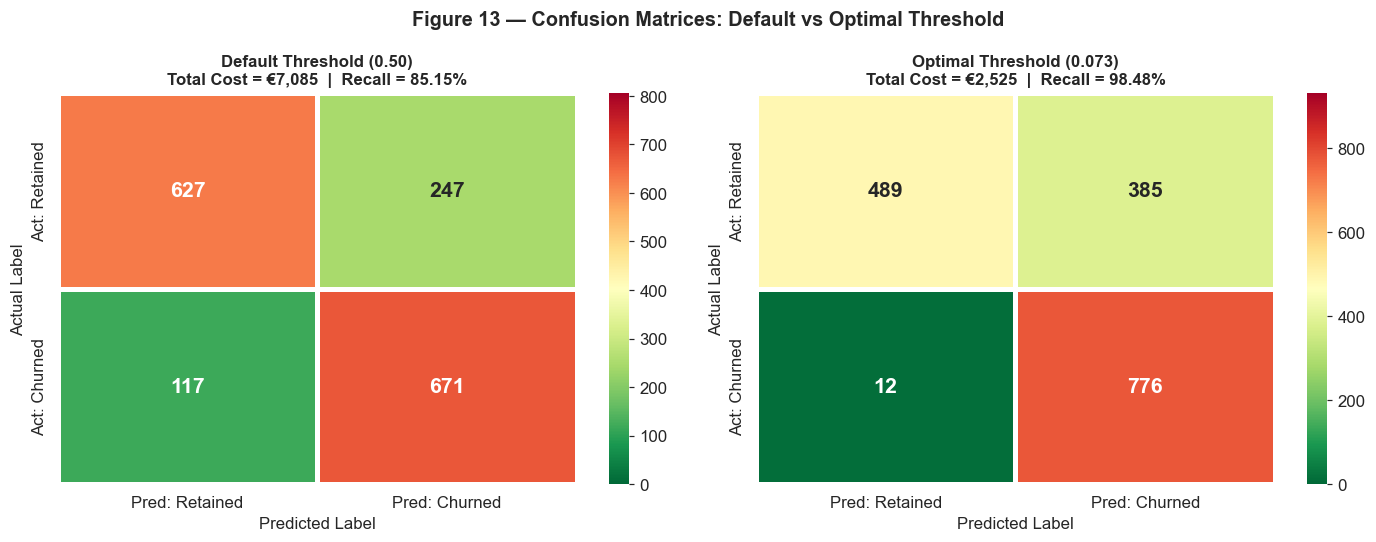

✅ Figure 13 saved.


In [49]:
# ── Final Visualization: Confusion Matrices Side by Side ─────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Figure 13 — Confusion Matrices: Default vs Optimal Threshold', fontsize=13, fontweight='bold')

for ax, cm, title, thresh_label in zip(
    axes,
    [cm_default, cm_optimal],
    ['Default Threshold (0.50)', f'Optimal Threshold ({thresh_opt:.3f})'],
    ['Default', 'Optimal']
):
    tn, fp, fn, tp = cm.ravel()
    total_cost = fn*COST_FN + fp*COST_FP

    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax,
                xticklabels=['Pred: Retained', 'Pred: Churned'],
                yticklabels=['Act: Retained', 'Act: Churned'],
                linewidths=2, linecolor='white', annot_kws={'size': 14, 'weight': 'bold'},
                vmin=0, vmax=max(tn, tp, fn, fp)*1.2)

    ax.set_title(f'{title}\nTotal Cost = €{total_cost:,.0f}  |  Recall = {tp/(tp+fn):.2%}',
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')

plt.tight_layout()
plt.savefig('fig13_cm_comparison.png', dpi=120, bbox_inches='tight')
plt.show()
print('✅ Figure 13 saved.')

### 📝 Detailed Interpretation — Figure 13: Confusion Matrix Comparison

**What the two heatmaps show:**
Side-by-side confusion matrices with the same color scale, making it easy to visually compare how predictions shift when we lower the threshold from 0.5 to the optimal value.

**Color coding:**
- **Green**: smaller values (fewer mistakes in error cells, fewer correct predictions in correct cells)
- **Red**: larger values
- The **diagonal** (TN top-left, TP bottom-right) should be large and dark-colored (many correct predictions).
- The **off-diagonal** (FP top-right, FN bottom-left) should be small and light.

**Reading the key differences:**

Moving from **Default → Optimal** threshold:

1. **FN decreases** (bottom-left cell shrinks): Fewer missed churners. Each prevented FN saves €50.
2. **TP increases** (bottom-right cell grows): More churners correctly identified and contacted for retention.
3. **FP increases** (top-right cell grows): More false alarms. Each additional FP costs €5.
4. **TN decreases** (top-left cell shrinks): Some previously-correctly-predicted loyal customers are now incorrectly flagged as churners.

**The business math:**
- Each FN prevented saves **€50**
- Each additional FP costs **€5**
- As long as we prevent more than 1 FN for every 10 FPs we introduce, the trade is profitable.
- The optimal threshold is precisely the point where this trade ceases to be profitable.

**Conclusion:**
> The optimal threshold demonstrates that **the business cost of a churn prediction model is not determined by its AUC** but by how its decision boundary is configured relative to the operational cost structure. The same model can deliver very different business value depending on the threshold used.

---
# ═══════════════════════════════════════════════════
# 📊 FINAL SUMMARY
# ═══════════════════════════════════════════════════

## Project Recap

In [50]:
# ── Full project summary ──────────────────────────────────────────────────────
print('=' * 65)
print('          PROJECT SUMMARY — CHURN PREDICTION & DRIFT')
print('=' * 65)
print()
print('DATASET')
print(f'  • 5,000 customer-period observations, 24 months')
print(f'  • Overall churn rate: {y.mean():.1%}')
print(f'  • NAs: Monthly_Amount 13.4%, Support_Calls 9.9%')
print()
print('DRIFT ANALYSIS (Steps 1–2)')
print(f'  • Target drift  : Churn rate rose from ~19% (P1) to ~56% (P24)')
print(f'  • Covariate drift: Monthly_Amount shows mild upward shift')
print(f'  • MNAR confirmed: Missing = 55%+ churn vs observed = 33% churn')
print(f'  • Missingness drift: NA rate for Monthly_Amount growing over time')
print()
print('PREPROCESSING (Step 3)')
print(f'  • Leakage-free Pipeline: imputer + scaler fitted on train only')
print(f'  • MNAR indicators added as explicit features')
print(f'  • Final feature count: {len(feature_names_final)}')
print()
print('MODELS (Steps 4 & 7)')
print(f'  • LR baseline  : AUC = {results_lr_best["auc"].mean():.4f} (rolling w={best_window})')
print(f'  • Random Forest: AUC = {results_rf["auc"].mean():.4f} (rolling w={best_window})')
print(f'  • Best model   : {best_model_name}')
print()
print('RETRAINING POLICIES (Steps 5–6)')
print(f'  • Fixed vs Rolling comparison completed')
print(f'  • Best window selected via offline backtesting: W = {best_window} periods')
print()
print('BUSINESS OPTIMIZATION (Step 8)')
print(f'  • COST_FN = €{COST_FN} | COST_FP = €{COST_FP} | Asymmetry = {COST_FN//COST_FP}×')
print(f'  • Default threshold 0.50 → Total cost: €{cost_05:,.0f}')
print(f'  • Optimal threshold {thresh_opt:.3f}  → Total cost: €{cost_opt:,.0f}')
print(f'  • Savings: €{cost_05-cost_opt:,.0f}  ({(cost_05-cost_opt)/cost_05:.1%} reduction)')
print()
print('KEY LESSONS')
print('  1. Never use random splits on temporal data — temporal leakage is real')
print('  2. Data drift is measurable and significant — 19% → 56% churn rise')
print('  3. MNAR is not just theoretical — it doubles the churn rate prediction')
print('  4. Window size is a hyperparameter — tune it offline via backtesting')
print('  5. AUC ≠ business value — threshold optimization can save thousands of €')
print()
print('=' * 65)
print('                  END OF PROJECT ✅')
print('=' * 65)

          PROJECT SUMMARY — CHURN PREDICTION & DRIFT

DATASET
  • 5,000 customer-period observations, 24 months
  • Overall churn rate: 36.4%
  • NAs: Monthly_Amount 13.4%, Support_Calls 9.9%

DRIFT ANALYSIS (Steps 1–2)
  • Target drift  : Churn rate rose from ~19% (P1) to ~56% (P24)
  • Covariate drift: Monthly_Amount shows mild upward shift
  • MNAR confirmed: Missing = 55%+ churn vs observed = 33% churn
  • Missingness drift: NA rate for Monthly_Amount growing over time

PREPROCESSING (Step 3)
  • Leakage-free Pipeline: imputer + scaler fitted on train only
  • MNAR indicators added as explicit features
  • Final feature count: 8

MODELS (Steps 4 & 7)
  • LR baseline  : AUC = 0.8654 (rolling w=5)
  • Random Forest: AUC = 0.8751 (rolling w=5)
  • Best model   : Random Forest

RETRAINING POLICIES (Steps 5–6)
  • Fixed vs Rolling comparison completed
  • Best window selected via offline backtesting: W = 5 periods

BUSINESS OPTIMIZATION (Step 8)
  • COST_FN = €50 | COST_FP = €5 | Asymme

---

## 📁 List of Generated Figures

| Figure | Filename | Content |
|---|---|---|
| 1 | `fig1_churn_per_period.png` | Churn rate per period — target drift |
| 2 | `fig2_covariate_drift.png` | Feature means over time — covariate drift |
| 3 | `fig3_early_vs_recent.png` | Distribution comparison: early vs recent |
| 4 | `fig4_missing_per_period.png` | Missingness rate per period |
| 5 | `fig5_mnar_analysis.png` | MNAR: missingness vs churn rate |
| 6 | `fig6_lr_roc_cm.png` | LR ROC curve & confusion matrix |
| 7 | `fig7_lr_rolling_auc.png` | LR performance drift per test period |
| 8 | `fig8_fixed_vs_rolling.png` | Fixed vs rolling retraining comparison |
| 9 | `fig9_window_selection.png` | Automatic window selection via backtesting |
| 10 | `fig10_lr_vs_rf.png` | LR vs Random Forest AUC comparison |
| 11 | `fig11_rf_feature_importance.png` | Random Forest feature importances |
| 12 | `fig12_cost_curve.png` | Business cost curve & recall/precision |
| 13 | `fig13_cm_comparison.png` | Default vs optimal threshold confusion matrices |

---
*Project complete. All code is reproducible — run all cells from top to bottom.*